this notebook does some spot checking on learned weight patterns in `scripts/training/yuanyuan_8k_a_3day/feature_approximation/k_bl_recurrent_k3/submit_sep2.py`.

It's interesting that PCA done here mimic those results in `results_processed/imagenet_val/feature_approximation/local_pcn_original_imagenet/pca_analysis.ipynb`.

Not sure if this is bad or good. But this seems to suggest some commonalities among recurrent models.

check `results_processed/yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/pca_analysis_20200218_layer3_kernelsize3or5.ipynb` as well. Maybe I should try another approximation function.


here, the original model's `ff` is not comparable to the approximator's `ff`, which consists the input plus a state.

for the `lateral`, I think I do see some correspondence. so PCA method is not totally off, if we use the correct model.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from thesis_v2 import dir_dict
from thesis_v2.training.training_aux import load_training_results

from thesis_v2.configs.model.feature_approximation import model_params_b_kl_recurrent_20200218

In [3]:
from sys import path
from os.path import join, exists, dirname
from os import makedirs



In [4]:
folder_to_check = 'scripts/training/yuanyuan_8k_a_3day/feature_approximation/k_bl_recurrent_k3'
path.insert(0, join(dir_dict['root'], folder_to_check))
from submit_sep2 import param_iterator, good_model_param

In [5]:
from numpy.linalg import norm
import numpy as np

In [6]:
from pickle import load

In [7]:
def load_one_result(filename):
    with open(filename, 'rb') as f:
        return load(f)

In [8]:
# create dir
global_vars = {
    'save_dir': join(dir_dict['analyses'],
                     'yuanyuan_8k_a_3day+feature_approximation+k_bl_recurrent_k3+submit_sep2+0',
                    'pca')
}

In [9]:
from math import sqrt
from torchvision.utils import make_grid
from torch import tensor

In [10]:
from sklearn.decomposition import PCA
from numpy.linalg import norm
import numpy as np

In [11]:
# compute ccmax
from strflab.stats import cc_max
from thesis_v2.data.prepared.yuanyuan_8k import get_neural_data_per_trial

cc_max_all_neurons = cc_max(get_neural_data_per_trial(
    ('042318', '043018','051018',))
                           )
assert cc_max_all_neurons.shape == (79,)

In [12]:
all_params_dict = model_params_b_kl_recurrent_20200218(good_model_param, legacy=False)

In [13]:
def calc_normed_pca(weight_matrix, verbose=False):
    # here `normed` means PCA after normalization of weight_matrix
    
    # there are multiple ways to define `normalization`
    # 
    # a simple way is to make each flattened filter with unit norm.
    weight_matrix_norm = norm(weight_matrix, axis=1, keepdims=True)
#     assert weight_matrix_norm.shape == (256,1)
    weight_matrix_normed = weight_matrix/weight_matrix_norm
    
    # tested, works as expected.
    if verbose:
        assert np.allclose(norm(weight_matrix_normed, axis=1), 1.0)
    
    
    # then let's do PCA
    pca_obj = PCA(svd_solver='full')
    pca_obj.fit(weight_matrix_normed)
    if verbose:
        # top 10 explains 60%;
        # top 20 explains 85%;
        # looks fine to me, compared to https://doi.org/10.1101/677237
        # "Recurrent networks can recycle neural resources to flexibly trade speed for accuracy in visual recognition"
        
        print(np.cumsum(pca_obj.explained_variance_ratio_)[:20])
        print(pca_obj.components_.shape)
    
    # then let's return and save them.
    return {
        'weight_matrix_norm': weight_matrix_norm,
        'weight_matrix': weight_matrix,
        'components': pca_obj.components_,
        'explained_variance_ratio': pca_obj.explained_variance_ratio_,
    }

def load_original_model_pca(base_model_idx):
    key = all_params_dict[base_model_idx]['key']
    
    result = load_training_results(key, return_model=False, return_checkpoint=True)
    cc_raw = np.asarray(result['stats_best']['stats']['test']['corr'])
    assert cc_raw.shape == (79,)
    # load loss curve to make sure we are good in approximation.
    corr_test = ((cc_raw/cc_max_all_neurons)**2).mean()
    # only keep 0.6+ models
#     if corr_test < 0.6:
#         continue

    # check layer one lateral.
    weight_np_ff = result['checkpoint']['model']['moduledict.bl_stack.layer_list.1.b_conv.weight'].numpy().astype(np.float64)
    weight_np_lateral = result['checkpoint']['model']['moduledict.bl_stack.layer_list.1.l_conv.weight'].numpy().astype(np.float64)

    kernel_shape = weight_np_ff.shape[2:]
    assert weight_np_ff.shape[2:] == weight_np_lateral.shape[2:] == kernel_shape
    assert weight_np_ff.ndim == weight_np_lateral.ndim == 4
    channel_low = weight_np_ff.shape[1]
    channel_high = weight_np_ff.shape[0]
    assert weight_np_lateral.shape[:2] == (channel_high, channel_high)

    weight_np_ff = weight_np_ff.reshape((channel_low*channel_high, kernel_shape[0]*kernel_shape[1]))
    weight_np_lateral = weight_np_lateral.reshape((channel_high*channel_high, kernel_shape[0]*kernel_shape[1]))

    pca_res_dict = dict()
    pca_res_dict['ff'] = calc_normed_pca(weight_np_ff)
    pca_res_dict['lateral'] = calc_normed_pca(weight_np_lateral)
    
    # show.
    print(f'original model {key}, corr_norm^2', corr_test)
    print('lateral')
    do_analysis_inner(pca_res_dict['lateral'])
    print('ff')
    do_analysis_inner(pca_res_dict['ff'])


In [14]:
def do_analysis_inner(data):
    components = data['components']
    assert components.ndim == 2
    n_el_per_filter = components.shape[1]
    kernel_size = round(sqrt(n_el_per_filter))
    assert type(kernel_size) is int and kernel_size**2 == n_el_per_filter
    components = components.reshape(components.shape[0], 1, kernel_size, kernel_size)

    # this components is ready to be displayed using pytorch's util
    components_grid = make_grid(tensor(components[:20]), nrow=10,normalize=True, scale_each=True)
    components_grid = components_grid.numpy().transpose(1, 2, 0)
    print(np.cumsum(data['explained_variance_ratio'])[:20])
    plt.close('all')
    plt.figure(figsize=(8,6))
    plt.imshow(components_grid,vmin=0.0,vmax=1.0,interpolation='none')
    plt.show()
        

def do_analysis(label_fname_list):
    for label, fname in label_fname_list:
        print(label)
        data = load_one_result(fname)
#         for x, y in data.items():
#             print(x, y.dtype, y.shape)
            
        
        # ok. what to show here?
        # first, let's reshape `components`.
        do_analysis_inner(data)

In [15]:
def collect_all():
    save_dir = global_vars['save_dir']
    count = 0
    for idx, data in enumerate(param_iterator(sep_start_range=(1,))):
        count += 1
        verbose = idx % 5 == 1
        
        
        
        key = data['key_this_original']
        
        def filename_gen(x):
            return join(save_dir, f'{idx}/unit_norm', f'{x}.pkl')
        
        filename_set = {'ff', 'lateral', 'all'}
        if not all([exists(filename_gen(x)) for x in filename_set]):
            # right now if partially done, the partial results will be fully overwritten.
            continue
            raise RuntimeError('bug!')
        
        if verbose:
            print(key)
            
            # load lateral one
            do_analysis([(x, filename_gen(x)) for x in [
                'lateral','ff',
                # remove this, confusing.
#                 'all'
            ]
                        ])
            
            baseidx = key.split('/')[2]
            assert baseidx.startswith('baseidx')
            baseidx = int(baseidx[7:])
            load_original_model_pca(baseidx)
        
        
    print(count)


yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx38/actrelu/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.24694341 0.40947743 0.55317567 0.65844515 0.72920839 0.78056854
 0.81428165 0.84152777 0.86282055 0.88148296 0.8954968  0.90823661
 0.92019985 0.92978961 0.93898174 0.94654707 0.95222727 0.95762693
 0.96262436 0.96700678]


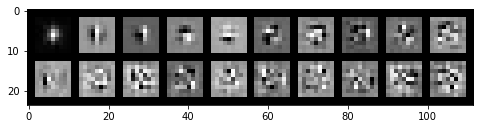

ff
[0.13667933 0.24526285 0.3446797  0.41605238 0.47471702 0.52230394
 0.56339261 0.59928944 0.63270115 0.66229652 0.69107808 0.71516677
 0.73645206 0.7553735  0.77290426 0.78960964 0.80417976 0.81821869
 0.83147338 0.84312552]


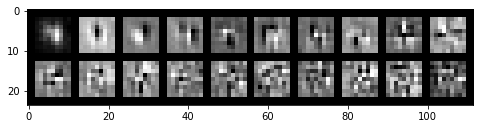

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch8/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lmse/m_se0, corr_norm^2 0.6199744284261657
lateral
[0.2181097  0.4188966  0.57590592 0.71460475 0.81284084 0.89182813
 0.932814   0.97078045 1.        ]


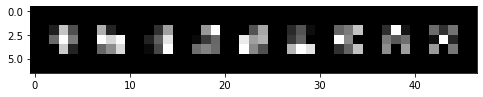

ff
[0.42355383 0.64092448 0.79328459 0.88597172 0.93578851 0.9664961
 0.98379255 0.99640658 1.        ]


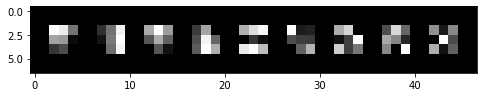

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx38/actsoftplus/lossl1/k9/bn_preTrue/model_seed0
lateral
[0.18157953 0.34445048 0.46824534 0.58549091 0.67280347 0.73003011
 0.77238628 0.80398111 0.83245625 0.85335057 0.87174684 0.8862295
 0.89922388 0.91073762 0.92046568 0.92942894 0.93712725 0.94394318
 0.95008823 0.95555036]


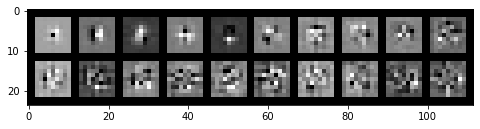

ff
[0.13827237 0.24363916 0.34706385 0.41263866 0.47068884 0.51935139
 0.56283052 0.60110267 0.63688376 0.66700797 0.68982455 0.71222326
 0.73259697 0.75085591 0.76867125 0.78514181 0.80025966 0.81385669
 0.8268987  0.83864421]


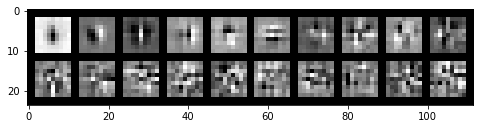

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch8/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lmse/m_se0, corr_norm^2 0.6199744284261657
lateral
[0.2181097  0.4188966  0.57590592 0.71460475 0.81284084 0.89182813
 0.932814   0.97078045 1.        ]


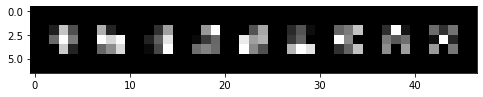

ff
[0.42355383 0.64092448 0.79328459 0.88597172 0.93578851 0.9664961
 0.98379255 0.99640658 1.        ]


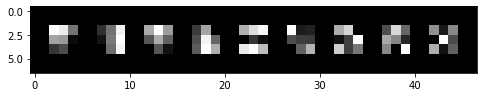

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx39/actrelu/lossl1/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.29293349 0.46193961 0.58980174 0.69512564 0.77515547 0.84517398
 0.87215139 0.89520247 0.91516237 0.92675393 0.93697094 0.94556836
 0.95253286 0.95918349 0.96475191 0.96974044 0.97351932 0.97666329
 0.97955309 0.98189119]


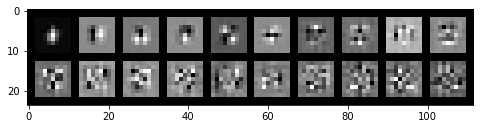

ff
[0.16524362 0.26862697 0.34937661 0.41824957 0.48293178 0.53826082
 0.58515928 0.6240334  0.65501032 0.68338138 0.70915458 0.73034095
 0.74968021 0.76793923 0.78512212 0.80097404 0.8155057  0.82903052
 0.841854   0.85337436]


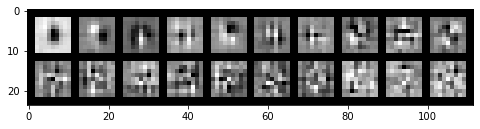

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch8/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lmse/m_se0, corr_norm^2 0.6221157100588468
lateral
[0.27231272 0.45458491 0.61669828 0.74722197 0.84040101 0.92494395
 0.96581581 0.98710616 1.        ]


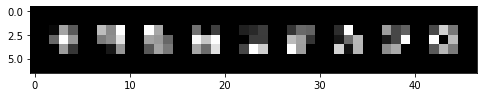

ff
[0.40717193 0.5764538  0.71192594 0.82123532 0.88799    0.94548753
 0.97088839 0.98920074 1.        ]


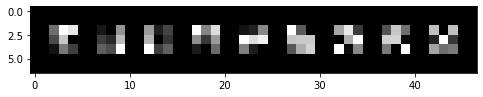

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx102/actrelu/lossmse/k9/bn_preTrue/model_seed0
lateral
[0.25786312 0.41625292 0.53333353 0.62406135 0.67648596 0.72238737
 0.75698398 0.78573596 0.80550414 0.82259026 0.83960576 0.85516645
 0.86895589 0.88011468 0.89055199 0.89993512 0.90812532 0.91487747
 0.92134312 0.92714501]


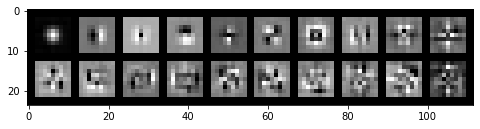

ff
[0.20535193 0.32339832 0.41403427 0.47464844 0.52655426 0.56716152
 0.60354168 0.63382038 0.65827019 0.6808757  0.70251012 0.72193801
 0.7395038  0.75657828 0.77109881 0.78464923 0.79737536 0.80861787
 0.81917339 0.82943177]


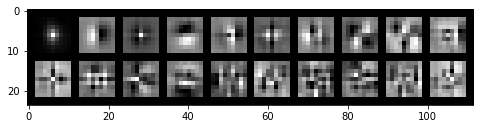

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch16/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lmse/m_se0, corr_norm^2 0.6603722007976168
lateral
[0.26162265 0.45017828 0.63175832 0.75463706 0.8493113  0.93752908
 0.96466704 0.9842369  1.        ]


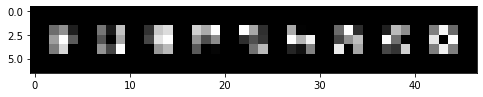

ff
[0.41421263 0.65084553 0.74944222 0.83982937 0.90318074 0.95472702
 0.97316721 0.9878388  1.        ]


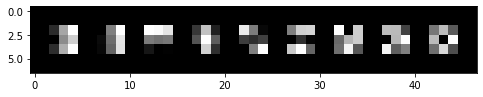

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx102/actsoftplus/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.34123507 0.50930197 0.61968491 0.70619474 0.75260111 0.78980478
 0.81818992 0.84323497 0.86002158 0.87405695 0.88729288 0.89935056
 0.90913946 0.91850594 0.92603882 0.93247771 0.93835297 0.94329685
 0.94805755 0.95191131]


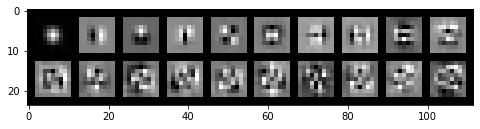

ff
[0.18604793 0.29115615 0.37471259 0.44731511 0.49686993 0.53818996
 0.5769198  0.61006543 0.63759964 0.6633749  0.68618138 0.70740761
 0.72544404 0.74188354 0.75643413 0.76973218 0.78208941 0.79306617
 0.803512   0.81363756]


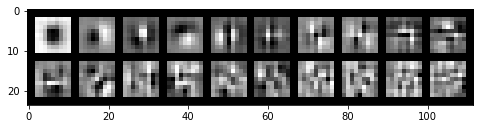

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch16/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lmse/m_se0, corr_norm^2 0.6603722007976168
lateral
[0.26162265 0.45017828 0.63175832 0.75463706 0.8493113  0.93752908
 0.96466704 0.9842369  1.        ]


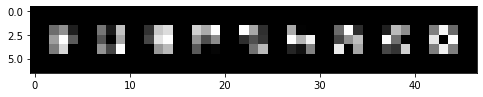

ff
[0.41421263 0.65084553 0.74944222 0.83982937 0.90318074 0.95472702
 0.97316721 0.9878388  1.        ]


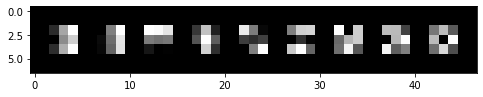

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx103/actrelu/lossl1/k9/bn_preTrue/model_seed0
lateral
[0.24782234 0.41176537 0.51247709 0.59627602 0.64734989 0.69010421
 0.72339592 0.7498954  0.77243403 0.79264614 0.80917663 0.82354355
 0.83755056 0.84859336 0.8586508  0.86732403 0.87495186 0.88242706
 0.88938048 0.89606739]


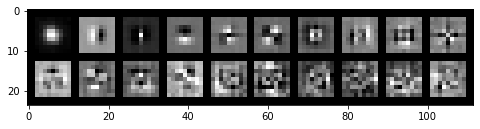

ff
[0.22640741 0.31996933 0.3988635  0.45342432 0.49889723 0.5374653
 0.57186725 0.60151649 0.62555355 0.64692954 0.66780295 0.68626903
 0.70447097 0.72175587 0.73783237 0.75260106 0.76405386 0.77495113
 0.78528903 0.79535025]


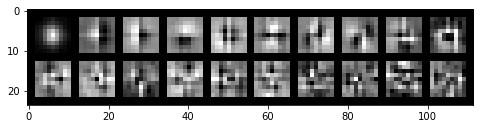

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch16/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lmse/m_se0, corr_norm^2 0.6523471258179373
lateral
[0.2392097  0.46151167 0.61769745 0.74361897 0.84038093 0.92386815
 0.95698429 0.98361211 1.        ]


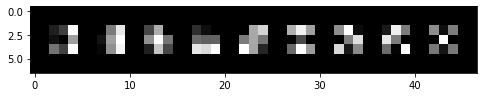

ff
[0.39796285 0.60145397 0.72387348 0.83361952 0.89956353 0.95589275
 0.97480156 0.9901872  1.        ]


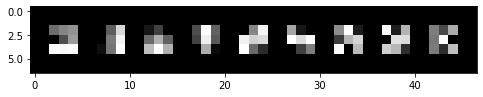

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx103/actsoftplus/lossl1/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.34377136 0.5384003  0.63625279 0.71528249 0.76370055 0.79905919
 0.82757177 0.84838454 0.86785826 0.8835843  0.89565069 0.90723146
 0.91635172 0.92393045 0.93067833 0.93696695 0.94258241 0.94698631
 0.95108924 0.95498279]


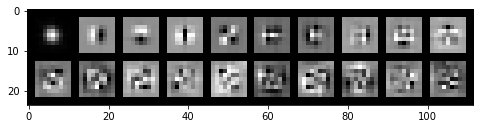

ff
[0.23103839 0.31691717 0.38487504 0.44791233 0.49472619 0.53993198
 0.57809597 0.61166357 0.63874733 0.66193494 0.68482555 0.70658436
 0.72620146 0.74256418 0.7582258  0.77260448 0.78690512 0.79857545
 0.80924965 0.81928044]


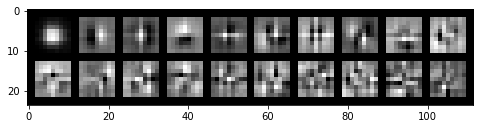

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch16/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lmse/m_se0, corr_norm^2 0.6523471258179373
lateral
[0.2392097  0.46151167 0.61769745 0.74361897 0.84038093 0.92386815
 0.95698429 0.98361211 1.        ]


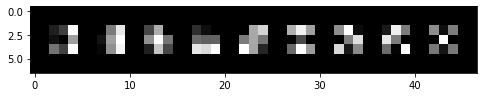

ff
[0.39796285 0.60145397 0.72387348 0.83361952 0.89956353 0.95589275
 0.97480156 0.9901872  1.        ]


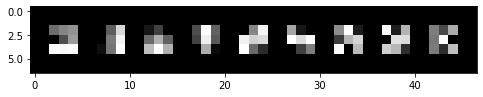

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx166/actsoftplus/lossmse/k9/bn_preTrue/model_seed0
lateral
[0.27214803 0.39619849 0.48732001 0.57012669 0.61822636 0.65842287
 0.69424471 0.72012488 0.74550412 0.76427129 0.78108909 0.79686008
 0.81116036 0.82365901 0.83476974 0.84543688 0.85491446 0.86303822
 0.87078139 0.87829115]


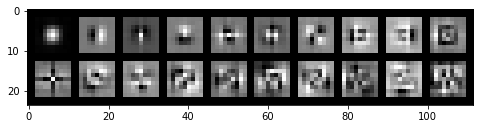

ff
[0.19450174 0.29132619 0.36529426 0.41642259 0.45909314 0.49571041
 0.52820748 0.55784778 0.58256574 0.60401311 0.62339787 0.64255856
 0.66134963 0.67746674 0.69327269 0.70716251 0.72038412 0.73205795
 0.74316987 0.75343996]


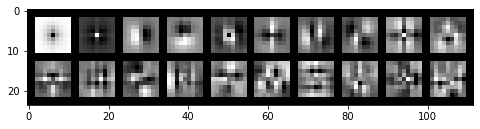

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch32/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lmse/m_se0, corr_norm^2 0.6736460960042622
lateral
[0.34235849 0.54086945 0.68305703 0.81138023 0.87309434 0.93239088
 0.95840411 0.98062543 1.        ]


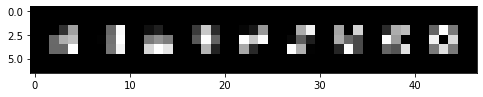

ff
[0.41290241 0.63053051 0.75868014 0.84463727 0.89581328 0.94291562
 0.96545125 0.98306534 1.        ]


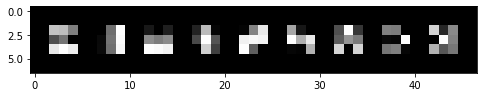

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx167/actrelu/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.3608557  0.50521075 0.59916191 0.66986058 0.71198193 0.75116703
 0.78217725 0.8085101  0.82620967 0.83974567 0.8525706  0.86451025
 0.87578133 0.8852281  0.89365441 0.90153453 0.90881302 0.91546907
 0.92077935 0.92565057]


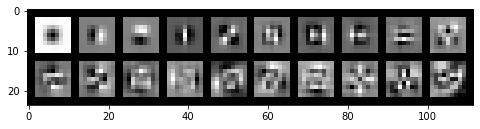

ff
[0.18550251 0.27858544 0.34882944 0.41149348 0.45268598 0.49299652
 0.53073138 0.5653312  0.5917083  0.61568574 0.63792191 0.65878211
 0.67867368 0.69749541 0.71491398 0.7293327  0.74231146 0.75482714
 0.76634971 0.77726251]


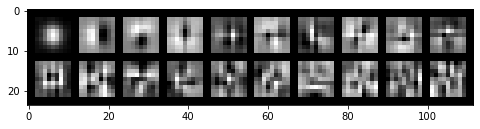

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch32/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lmse/m_se0, corr_norm^2 0.6750737402088446
lateral
[0.34251664 0.52504579 0.66473192 0.79529771 0.87432048 0.93457955
 0.95953124 0.98165511 1.        ]


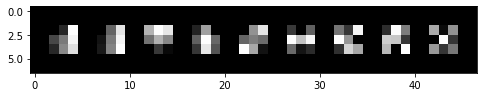

ff
[0.39558952 0.60124142 0.73544128 0.82904253 0.89246262 0.94260988
 0.96516394 0.98561662 1.        ]


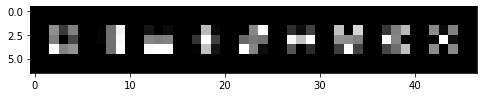

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx167/actsoftplus/lossl1/k9/bn_preTrue/model_seed0
lateral
[0.28324284 0.41130443 0.49766655 0.58059485 0.62791358 0.67054892
 0.70968732 0.74006451 0.7625682  0.78119158 0.79680401 0.81197291
 0.82551367 0.8378195  0.84906754 0.85901007 0.86817197 0.87644636
 0.88347425 0.89005207]


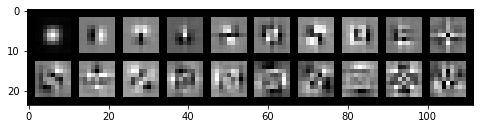

ff
[0.19425466 0.28069661 0.35864982 0.41738174 0.45906611 0.49720976
 0.53233627 0.56364057 0.58945733 0.61405173 0.63719645 0.6565374
 0.67459959 0.6922364  0.70888467 0.72302624 0.73580301 0.74714091
 0.75797322 0.76857486]


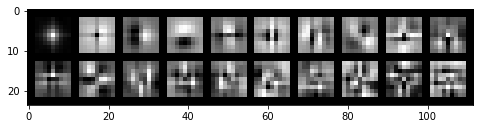

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch32/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lmse/m_se0, corr_norm^2 0.6750737402088446
lateral
[0.34251664 0.52504579 0.66473192 0.79529771 0.87432048 0.93457955
 0.95953124 0.98165511 1.        ]


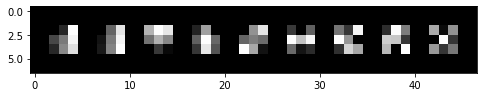

ff
[0.39558952 0.60124142 0.73544128 0.82904253 0.89246262 0.94260988
 0.96516394 0.98561662 1.        ]


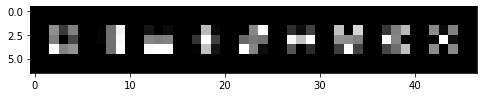

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx230/actrelu/lossl1/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.26070019 0.43147505 0.58522604 0.6762773  0.74047348 0.79999074
 0.83460438 0.86472602 0.88682969 0.90247973 0.91595379 0.92631589
 0.93568616 0.94258929 0.94899019 0.95515842 0.96008318 0.9644818
 0.96804656 0.97156034]


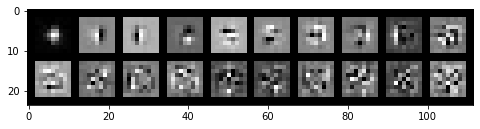

ff
[0.16586802 0.27317769 0.35730403 0.43224378 0.49670805 0.54896284
 0.58819701 0.62190281 0.65355348 0.68234858 0.70671581 0.72990771
 0.74961553 0.76800066 0.78495326 0.80066592 0.81529687 0.8278683
 0.83963881 0.85042867]


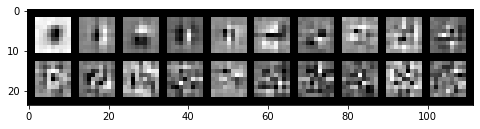

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch8/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lpoisson/m_se0, corr_norm^2 0.6202113663302079
lateral
[0.28844672 0.470011   0.62010623 0.75310027 0.87550955 0.92236089
 0.95758468 0.98364015 1.        ]


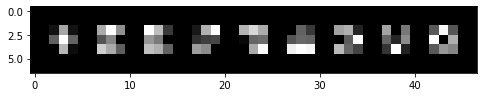

ff
[0.40225701 0.56651459 0.70554477 0.83346083 0.9130745  0.95959789
 0.97688056 0.99032718 1.        ]


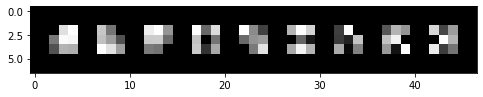

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx231/actrelu/lossmse/k9/bn_preTrue/model_seed0
lateral
[0.23218268 0.39525576 0.5240012  0.60862373 0.66977156 0.71934435
 0.76156002 0.80162023 0.83325497 0.85676065 0.87623104 0.89261405
 0.90720405 0.91812542 0.92730685 0.93568422 0.9433274  0.95025542
 0.95623625 0.96128741]


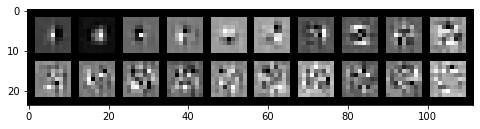

ff
[0.19625028 0.31578295 0.40628458 0.46568895 0.52279589 0.57278157
 0.61229277 0.64621228 0.67668599 0.70188222 0.72480268 0.74550898
 0.76552876 0.78258642 0.79804574 0.81281401 0.82673543 0.83990491
 0.85064942 0.86078523]


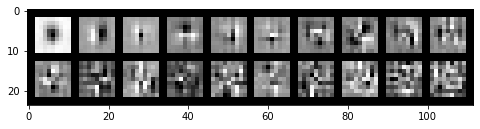

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch8/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lpoisson/m_se0, corr_norm^2 0.613888058953329
lateral
[0.29512563 0.49684959 0.66573098 0.78513668 0.86734268 0.93938986
 0.96259875 0.98356116 1.        ]


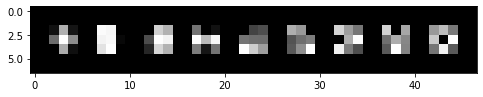

ff
[0.50667186 0.66621113 0.78460792 0.88588965 0.93107609 0.96225116
 0.97802985 0.99040971 1.        ]


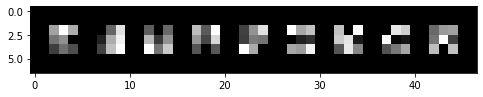

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx231/actsoftplus/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.3192122  0.49830233 0.59902934 0.67288713 0.7305858  0.77938533
 0.81744359 0.85267377 0.87701602 0.89532785 0.90904871 0.92132674
 0.93143438 0.93913635 0.94637461 0.95298843 0.95902093 0.96425409
 0.96880928 0.97237448]


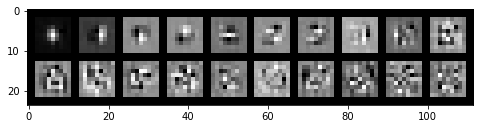

ff
[0.2323104  0.36868912 0.4443057  0.50902288 0.56651915 0.60984253
 0.64644184 0.6782291  0.70508201 0.73003216 0.75332686 0.77483031
 0.79391827 0.81183517 0.82860786 0.8428122  0.85618055 0.86757275
 0.8768287  0.88585865]


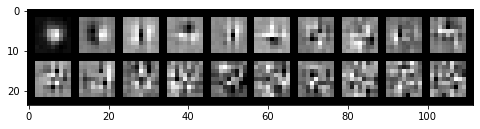

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch8/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lpoisson/m_se0, corr_norm^2 0.613888058953329
lateral
[0.29512563 0.49684959 0.66573098 0.78513668 0.86734268 0.93938986
 0.96259875 0.98356116 1.        ]


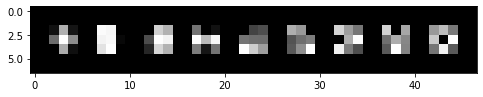

ff
[0.50667186 0.66621113 0.78460792 0.88588965 0.93107609 0.96225116
 0.97802985 0.99040971 1.        ]


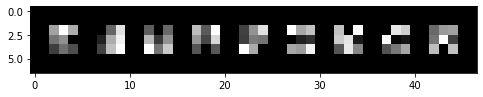

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx294/actrelu/lossl1/k9/bn_preTrue/model_seed0
lateral
[0.25947982 0.40769535 0.50676145 0.58184327 0.63287139 0.66656922
 0.6943876  0.72041946 0.74188996 0.76099264 0.77977887 0.79472235
 0.80861625 0.82075566 0.83233003 0.84306193 0.85174306 0.86010252
 0.86755464 0.87447286]


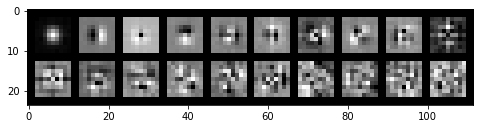

ff
[0.20091891 0.29509239 0.37903148 0.42887399 0.47686795 0.51408019
 0.54792906 0.57417938 0.59833885 0.62052743 0.64084995 0.65937218
 0.67662445 0.69302267 0.70863304 0.72170103 0.73395737 0.74590063
 0.75711256 0.76677196]


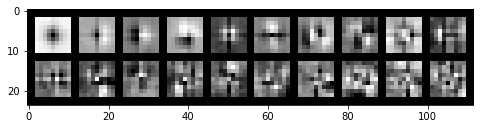

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch16/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lpoisson/m_se0, corr_norm^2 0.6550169753428134
lateral
[0.31400755 0.52665771 0.68571746 0.80013877 0.87586954 0.94153735
 0.96886033 0.98683887 1.        ]


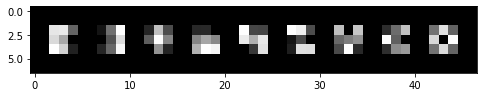

ff
[0.4026875  0.62703879 0.73781544 0.83876733 0.90767274 0.95232296
 0.97236944 0.98894505 1.        ]


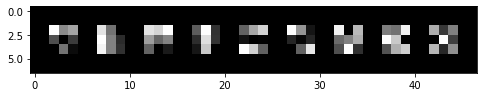

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx294/actsoftplus/lossl1/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.37880668 0.55399614 0.64638578 0.71475604 0.76595289 0.79781565
 0.82524459 0.84749208 0.86690814 0.88192059 0.89400074 0.9040591
 0.91262734 0.92057779 0.92686221 0.93266889 0.9377281  0.94218262
 0.94641204 0.95003493]


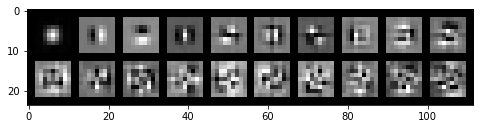

ff
[0.22591987 0.33861632 0.41159647 0.47926425 0.52324838 0.56605082
 0.60304864 0.63536224 0.6587779  0.6802574  0.70009542 0.71840955
 0.73527695 0.75113142 0.76540152 0.77932882 0.7914144  0.80190309
 0.81203475 0.82186692]


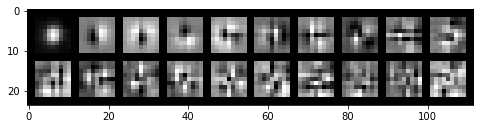

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch16/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lpoisson/m_se0, corr_norm^2 0.6550169753428134
lateral
[0.31400755 0.52665771 0.68571746 0.80013877 0.87586954 0.94153735
 0.96886033 0.98683887 1.        ]


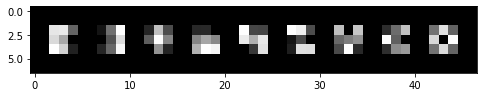

ff
[0.4026875  0.62703879 0.73781544 0.83876733 0.90767274 0.95232296
 0.97236944 0.98894505 1.        ]


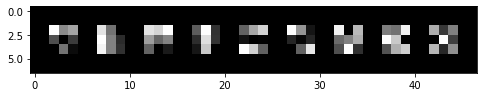

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx295/actsoftplus/lossmse/k9/bn_preTrue/model_seed0
lateral
[0.23984494 0.39534248 0.50724887 0.58557883 0.64970517 0.70352116
 0.73937297 0.77316267 0.80121468 0.82163576 0.83726744 0.85259824
 0.86542648 0.87779862 0.88725606 0.8955719  0.90333001 0.91036234
 0.91663771 0.92259131]


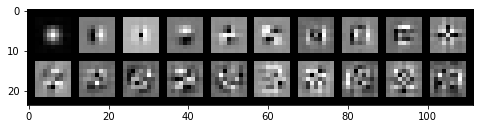

ff
[0.18973187 0.2725074  0.34218963 0.40739397 0.45361767 0.49302271
 0.52821228 0.56251489 0.59130291 0.61552998 0.63689164 0.65619859
 0.67459793 0.69280086 0.70894691 0.72395513 0.73829276 0.75191328
 0.76316289 0.77416631]


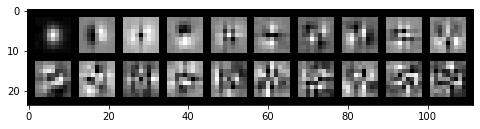

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch16/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lpoisson/m_se0, corr_norm^2 0.6520136521993494
lateral
[0.26316808 0.46605782 0.63802585 0.756059   0.85508801 0.9382403
 0.96307409 0.98577071 1.        ]


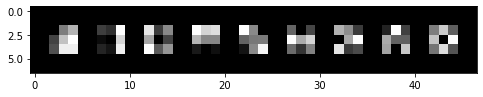

ff
[0.40036323 0.60994989 0.74809035 0.83456086 0.89576471 0.95272048
 0.97172605 0.98681778 1.        ]


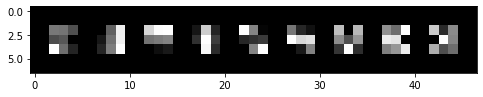

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx358/actrelu/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.41230381 0.55456709 0.64563153 0.70281096 0.73552582 0.76224998
 0.78765093 0.80950693 0.82710822 0.84193993 0.85457402 0.86564011
 0.8755583  0.88455707 0.89292657 0.89963998 0.9061826  0.91244284
 0.91798598 0.92277233]


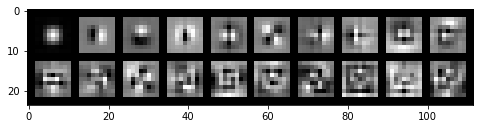

ff
[0.22203277 0.31402869 0.38928586 0.44964552 0.49150972 0.52916127
 0.56352097 0.59323107 0.61983057 0.64491119 0.66459938 0.68344097
 0.69971049 0.71554297 0.72928833 0.74161157 0.75378442 0.76485158
 0.77549005 0.78538148]


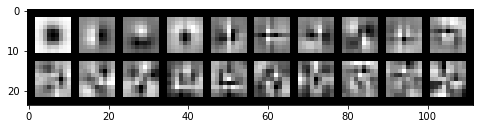

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch32/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lpoisson/m_se0, corr_norm^2 0.6531110151470141
lateral
[0.42073296 0.5979005  0.70944279 0.80829159 0.86356553 0.91382523
 0.94495005 0.97353411 1.        ]


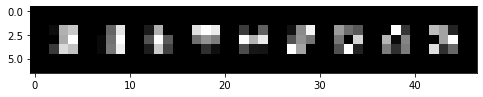

ff
[0.39764171 0.61381656 0.74245459 0.82107585 0.87533197 0.92168124
 0.95144348 0.97767321 1.        ]


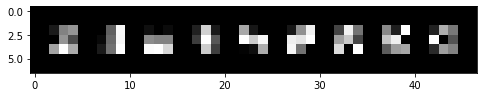

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx358/actsoftplus/lossl1/k9/bn_preTrue/model_seed0
lateral
[0.28518148 0.39888927 0.47971288 0.54754167 0.59667895 0.63396841
 0.66132941 0.68592077 0.70831239 0.72876388 0.74723232 0.76290092
 0.77797043 0.79105384 0.80174906 0.81134208 0.82010264 0.82821739
 0.83596433 0.84323854]


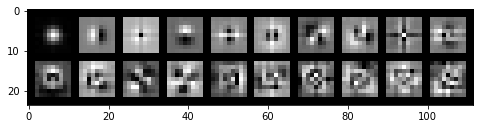

ff
[0.28776719 0.37341032 0.4366167  0.48705485 0.52661053 0.55855603
 0.58406378 0.60818004 0.62981101 0.64886994 0.66724257 0.68272996
 0.69753925 0.71038095 0.72282558 0.73409761 0.74432727 0.75425992
 0.76309667 0.77120335]


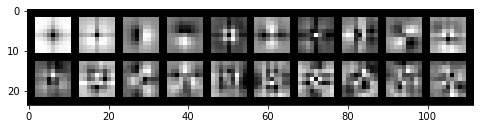

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch32/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lpoisson/m_se0, corr_norm^2 0.6531110151470141
lateral
[0.42073296 0.5979005  0.70944279 0.80829159 0.86356553 0.91382523
 0.94495005 0.97353411 1.        ]


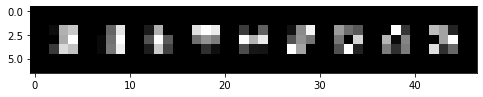

ff
[0.39764171 0.61381656 0.74245459 0.82107585 0.87533197 0.92168124
 0.95144348 0.97767321 1.        ]


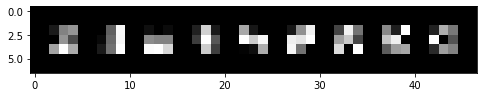

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx359/actrelu/lossl1/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.4192613  0.54932147 0.62321007 0.68906887 0.72782373 0.75740331
 0.78363055 0.80591442 0.82173902 0.83718496 0.85184438 0.86355542
 0.87380098 0.88289433 0.89113    0.89926102 0.90611434 0.91257575
 0.91824535 0.92337288]


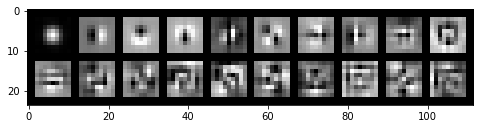

ff
[0.21580921 0.31746255 0.39809182 0.46627448 0.50551639 0.5433136
 0.57781619 0.60917338 0.63503063 0.65918816 0.68099516 0.70071081
 0.71789961 0.73439121 0.75046415 0.76411032 0.77677859 0.78772599
 0.79845167 0.80846335]


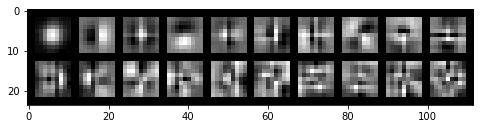

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch32/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lpoisson/m_se0, corr_norm^2 0.6744943468986788
lateral
[0.41813029 0.5912939  0.72093442 0.82105805 0.87624134 0.92874773
 0.95540262 0.97838483 1.        ]


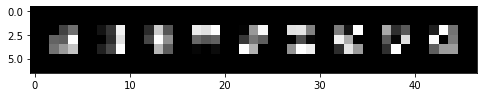

ff
[0.40593363 0.60980985 0.7463964  0.83303101 0.88525723 0.93390397
 0.96041233 0.98178625 1.        ]


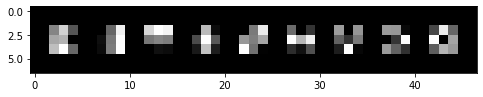

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx422/actrelu/lossmse/k9/bn_preTrue/model_seed0
lateral
[0.19720338 0.36878933 0.48562225 0.57917417 0.65731432 0.72102947
 0.76717437 0.80563385 0.83640627 0.86047482 0.87809554 0.89418375
 0.90774299 0.91861701 0.92877844 0.93735556 0.94497304 0.9517175
 0.95727071 0.96255471]


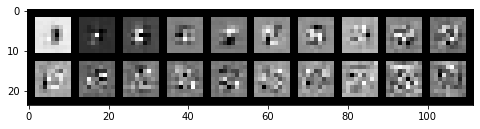

ff
[0.22367182 0.31294217 0.39198106 0.46289646 0.51604319 0.56418085
 0.60301838 0.64020661 0.67275356 0.69746226 0.72058399 0.7411243
 0.75971433 0.77789455 0.79503128 0.81000642 0.82402968 0.83644247
 0.84848995 0.85888553]


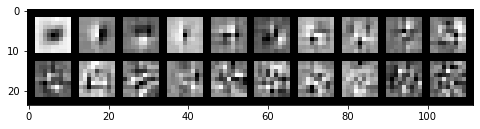

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch8/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lmse/m_se0, corr_norm^2 0.6171231446799375
lateral
[0.22678999 0.43264736 0.59834925 0.71478337 0.81573969 0.90321496
 0.94705079 0.98407529 1.        ]


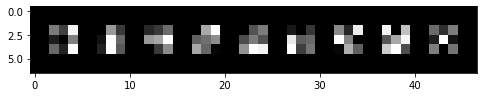

ff
[0.4535034  0.67149126 0.78140279 0.86910328 0.92554056 0.96873106
 0.98399666 0.9928525  1.        ]


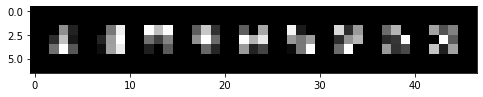

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx422/actsoftplus/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.29500712 0.44804072 0.5475225  0.64046117 0.71372857 0.76575415
 0.80563551 0.84331688 0.87075944 0.89160389 0.90613437 0.91875086
 0.93071478 0.94026557 0.94893285 0.95558803 0.9608635  0.9657952
 0.96983388 0.9736113 ]


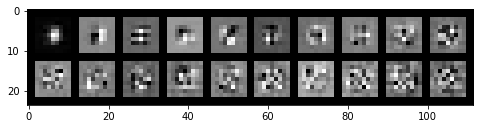

ff
[0.20430674 0.30957154 0.38887982 0.4517051  0.50746311 0.55926773
 0.6011894  0.63838677 0.66820711 0.69516775 0.71961698 0.74278885
 0.76339451 0.78245227 0.7985294  0.81284126 0.82671547 0.84012054
 0.85210409 0.86355201]


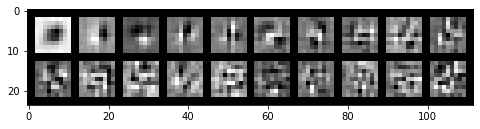

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch8/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lmse/m_se0, corr_norm^2 0.6171231446799375
lateral
[0.22678999 0.43264736 0.59834925 0.71478337 0.81573969 0.90321496
 0.94705079 0.98407529 1.        ]


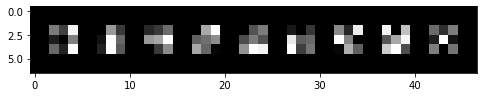

ff
[0.4535034  0.67149126 0.78140279 0.86910328 0.92554056 0.96873106
 0.98399666 0.9928525  1.        ]


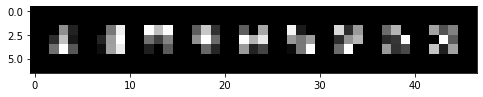

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx423/actrelu/lossl1/k9/bn_preTrue/model_seed0
lateral
[0.33149423 0.49411678 0.60194191 0.66587572 0.72468164 0.7674572
 0.80653646 0.83721596 0.86392569 0.88131778 0.89643248 0.90854432
 0.92013261 0.93065854 0.93869097 0.94621861 0.95308146 0.95898806
 0.96384696 0.96803373]


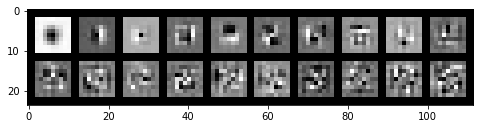

ff
[0.26955845 0.39581519 0.48189539 0.53589914 0.58129577 0.61669115
 0.64993447 0.67943369 0.70441761 0.7275081  0.74830463 0.76754422
 0.7851367  0.80155983 0.81540927 0.82769195 0.83961906 0.84986968
 0.85974346 0.8694689 ]


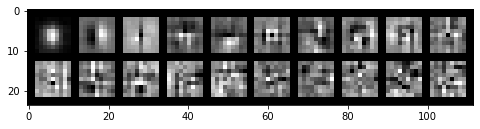

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch8/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lmse/m_se0, corr_norm^2 0.5829883740230418
lateral
[0.33721873 0.52890803 0.66869545 0.77867213 0.86764949 0.93757133
 0.96522887 0.98994514 1.        ]


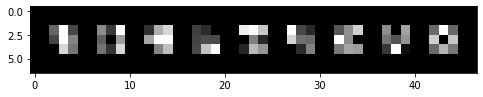

ff
[0.55272197 0.68986049 0.80735325 0.88625723 0.93911922 0.96402606
 0.98021925 0.99235637 1.        ]


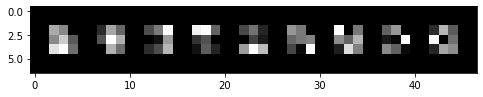

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx423/actsoftplus/lossl1/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.37700189 0.54450625 0.62471199 0.69431851 0.75557432 0.79495001
 0.83077834 0.86019592 0.88609252 0.90406173 0.91978388 0.93060304
 0.93993148 0.94790149 0.95439926 0.96022056 0.96536171 0.97004829
 0.97348791 0.97682048]


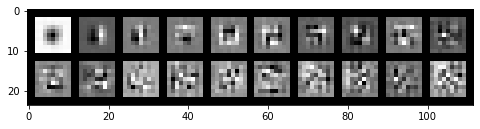

ff
[0.30543244 0.44621073 0.53922761 0.59777264 0.63581344 0.67097416
 0.70525103 0.73456143 0.76150006 0.78421761 0.80363953 0.82048143
 0.83635774 0.85065109 0.86182241 0.87201634 0.8817139  0.89030318
 0.89838092 0.90547716]


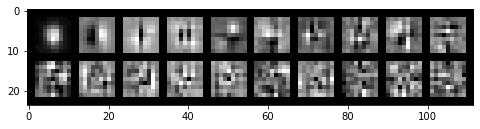

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch8/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lmse/m_se0, corr_norm^2 0.5829883740230418
lateral
[0.33721873 0.52890803 0.66869545 0.77867213 0.86764949 0.93757133
 0.96522887 0.98994514 1.        ]


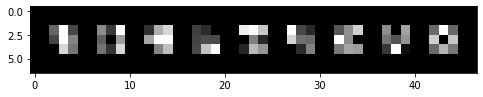

ff
[0.55272197 0.68986049 0.80735325 0.88625723 0.93911922 0.96402606
 0.98021925 0.99235637 1.        ]


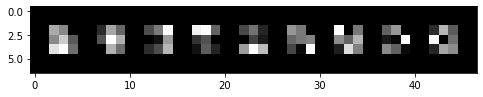

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx486/actsoftplus/lossmse/k9/bn_preTrue/model_seed0
lateral
[0.23725884 0.38968177 0.4925961  0.57404731 0.63100089 0.68465876
 0.72198873 0.75848055 0.78844524 0.80866949 0.82514372 0.84091247
 0.85505337 0.86769824 0.87867803 0.88797017 0.89654278 0.9039905
 0.91105948 0.91782123]


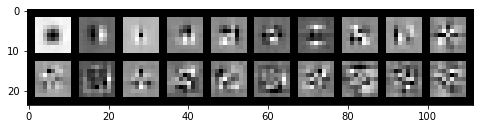

ff
[0.20931233 0.31269465 0.38489506 0.45401601 0.49769553 0.53773941
 0.56961477 0.59742542 0.6235355  0.64649049 0.66819071 0.68666031
 0.70330636 0.71882832 0.73388354 0.74750734 0.75986258 0.77137257
 0.78220519 0.79288178]


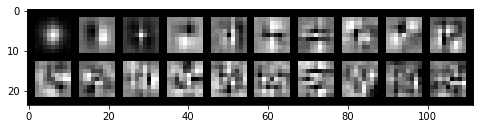

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch16/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lmse/m_se0, corr_norm^2 0.643946919324279
lateral
[0.34176805 0.53054622 0.67985176 0.77691911 0.86466165 0.9325978
 0.95979    0.98472261 1.        ]


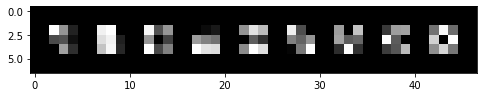

ff
[0.50737139 0.6802125  0.79495935 0.88304724 0.93198714 0.96498494
 0.98041806 0.99178206 1.        ]


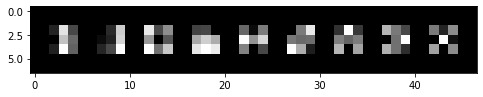

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx487/actrelu/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.31555078 0.4628328  0.54270003 0.60897367 0.67124496 0.72282835
 0.76231885 0.79549294 0.81809167 0.83650968 0.85362658 0.86852138
 0.88039264 0.89143107 0.90113383 0.90949166 0.91707534 0.92435956
 0.93114554 0.93672037]


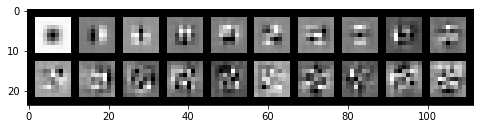

ff
[0.23522458 0.33484093 0.4092811  0.46949537 0.51899905 0.55411951
 0.58902266 0.61894911 0.64617549 0.67004874 0.69127754 0.71045674
 0.72856862 0.74491817 0.76031921 0.7744054  0.78672967 0.79809069
 0.80844958 0.81832744]


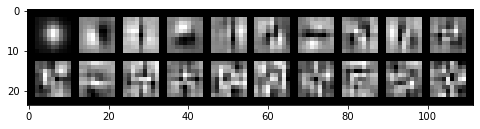

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch16/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lmse/m_se0, corr_norm^2 0.6470075997292409
lateral
[0.32376155 0.50114593 0.66404533 0.76765608 0.86224256 0.9426035
 0.96643908 0.98507143 1.        ]


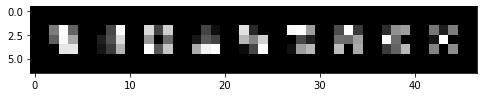

ff
[0.46479795 0.65215885 0.77378652 0.87694265 0.92541978 0.9659091
 0.98095278 0.99117323 1.        ]


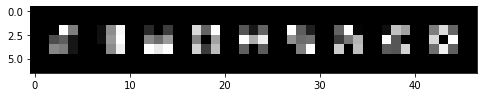

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx487/actsoftplus/lossl1/k9/bn_preTrue/model_seed0
lateral
[0.25993649 0.39525112 0.4874927  0.56046584 0.61933512 0.67549979
 0.72290833 0.75936376 0.78353639 0.80353745 0.82161401 0.83905177
 0.85404638 0.86545561 0.87635506 0.88584965 0.89448696 0.90244463
 0.90943083 0.91575396]


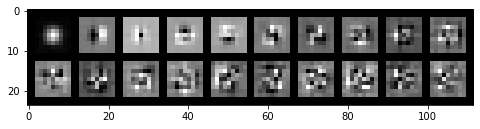

ff
[0.23471444 0.3266446  0.40453479 0.45729165 0.50189471 0.53940849
 0.57253365 0.60026315 0.62737218 0.65104335 0.67409183 0.69468173
 0.71262425 0.72915498 0.74488446 0.75880934 0.77070719 0.78228905
 0.79257572 0.80254376]


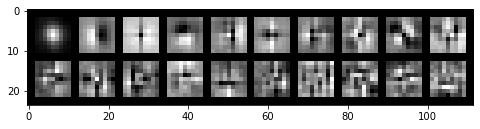

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch16/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lmse/m_se0, corr_norm^2 0.6470075997292409
lateral
[0.32376155 0.50114593 0.66404533 0.76765608 0.86224256 0.9426035
 0.96643908 0.98507143 1.        ]


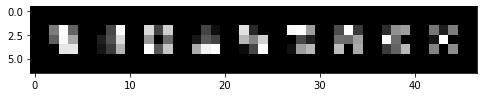

ff
[0.46479795 0.65215885 0.77378652 0.87694265 0.92541978 0.9659091
 0.98095278 0.99117323 1.        ]


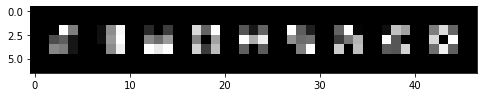

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx550/actrelu/lossl1/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.33841637 0.47710057 0.57032984 0.63141624 0.6767137  0.71395717
 0.74595999 0.77420737 0.80138906 0.81957429 0.83585103 0.84965189
 0.86300935 0.87220154 0.88125146 0.88966241 0.89742507 0.9040288
 0.90973342 0.91529249]


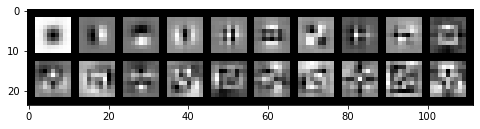

ff
[0.20289913 0.30462769 0.378919   0.44070538 0.48661106 0.52622955
 0.56018873 0.59109239 0.61882651 0.64101543 0.66173505 0.68085795
 0.69871604 0.71524991 0.73008212 0.74378579 0.75608641 0.76789244
 0.77915911 0.78922985]


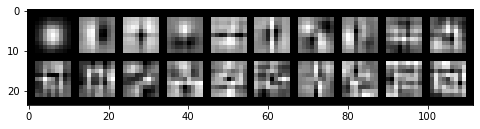

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch32/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lmse/m_se0, corr_norm^2 0.6588477669205479
lateral
[0.38729432 0.57641002 0.7089301  0.81917754 0.89109119 0.95298437
 0.97108109 0.9868539  1.        ]


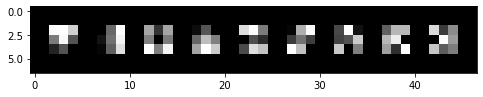

ff
[0.43108533 0.63698555 0.76602259 0.87482358 0.92158593 0.95981701
 0.97574029 0.98823792 1.        ]


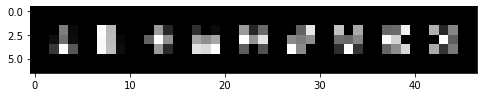

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx551/actrelu/lossmse/k9/bn_preTrue/model_seed0
lateral
[0.32218377 0.42792799 0.50371949 0.5705076  0.62409307 0.65777281
 0.6906341  0.72042106 0.74765008 0.76681978 0.78394694 0.800055
 0.81515583 0.8290793  0.84036375 0.85096133 0.86028414 0.86883812
 0.87623046 0.88302688]


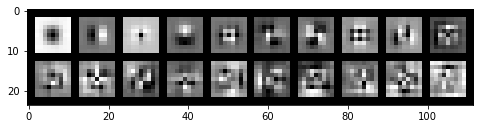

ff
[0.21736441 0.31416818 0.38790163 0.44838185 0.48754447 0.52255556
 0.55188012 0.57930516 0.6015282  0.6222345  0.64081594 0.65694809
 0.67255547 0.68754645 0.70076576 0.71351428 0.72492133 0.73552687
 0.74583898 0.7553078 ]


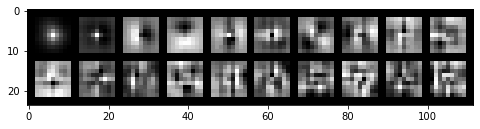

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch32/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lmse/m_se0, corr_norm^2 0.6603923727200528
lateral
[0.4316147  0.58790694 0.71448592 0.81611771 0.88577792 0.94092194
 0.96237851 0.98221299 1.        ]


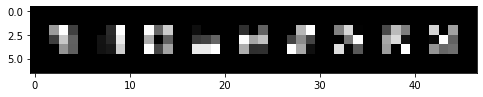

ff
[0.43285569 0.62797496 0.76014061 0.85889624 0.91056943 0.95077299
 0.96873146 0.98649374 1.        ]


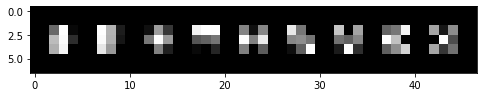

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx551/actsoftplus/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.39100632 0.51341068 0.58877571 0.64834924 0.69434241 0.72905654
 0.760613   0.78990941 0.81636528 0.83217445 0.84679363 0.86058809
 0.87242749 0.88246478 0.89104709 0.89835515 0.9054747  0.91143382
 0.9168273  0.92188121]


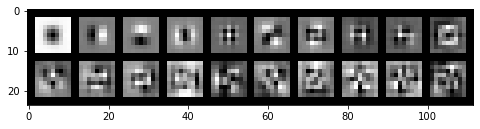

ff
[0.20323111 0.29176063 0.36567369 0.42756451 0.47108806 0.50614766
 0.53899992 0.56896881 0.59198697 0.6126825  0.63201601 0.65020961
 0.66636357 0.68219969 0.69758922 0.7115198  0.72413758 0.73565391
 0.74680014 0.75721594]


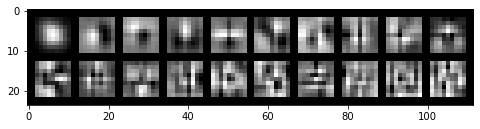

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch32/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lmse/m_se0, corr_norm^2 0.6603923727200528
lateral
[0.4316147  0.58790694 0.71448592 0.81611771 0.88577792 0.94092194
 0.96237851 0.98221299 1.        ]


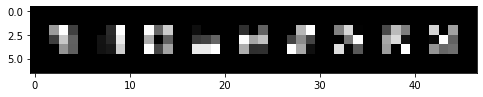

ff
[0.43285569 0.62797496 0.76014061 0.85889624 0.91056943 0.95077299
 0.96873146 0.98649374 1.        ]


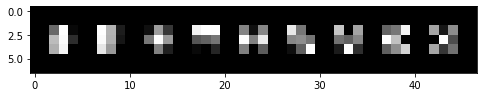

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx614/actrelu/lossl1/k9/bn_preTrue/model_seed0
lateral
[0.23356633 0.41410316 0.50726104 0.58946359 0.65679198 0.70698358
 0.75314186 0.78759898 0.81602408 0.84225429 0.86109254 0.87872399
 0.89362233 0.90687809 0.91918749 0.92982338 0.93760381 0.945022
 0.95099309 0.95613136]


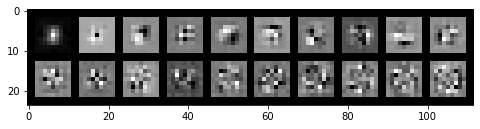

ff
[0.25140668 0.36767138 0.45026397 0.5104811  0.56056057 0.60126859
 0.63746046 0.66977999 0.69904073 0.72265408 0.74345058 0.76353586
 0.78194426 0.79918452 0.81337464 0.82708958 0.83863477 0.84936176
 0.85950078 0.8688138 ]


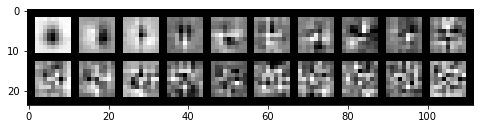

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch8/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lpoisson/m_se0, corr_norm^2 0.6193433435604665
lateral
[0.26660731 0.46526361 0.60981551 0.74174718 0.83113281 0.91330684
 0.95394259 0.98395998 1.        ]


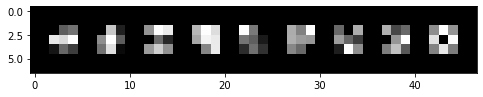

ff
[0.52834281 0.71829227 0.82450548 0.87909716 0.92533497 0.96057176
 0.97650264 0.98978334 1.        ]


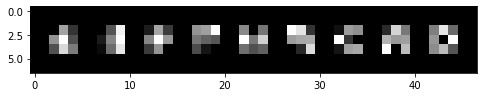

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx614/actsoftplus/lossl1/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.32202468 0.44514961 0.54636516 0.62421794 0.68765725 0.73243607
 0.77283339 0.80213263 0.8283945  0.85315895 0.87474005 0.89228969
 0.90628681 0.91906567 0.92900142 0.93799943 0.94636826 0.9537972
 0.95941563 0.96462002]


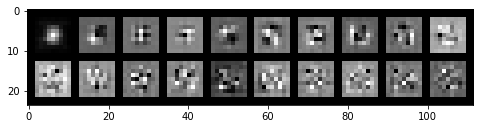

ff
[0.28471426 0.38779878 0.46439413 0.53440062 0.58359342 0.62626592
 0.66315477 0.6944487  0.72150672 0.74590951 0.7667943  0.7856337
 0.80396352 0.82070195 0.83538984 0.84934767 0.8609451  0.87179616
 0.88095245 0.88904895]


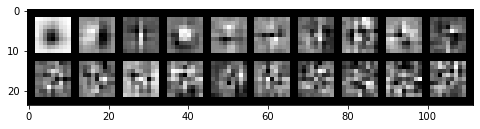

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch8/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lpoisson/m_se0, corr_norm^2 0.6193433435604665
lateral
[0.26660731 0.46526361 0.60981551 0.74174718 0.83113281 0.91330684
 0.95394259 0.98395998 1.        ]


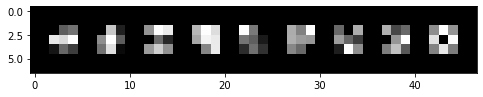

ff
[0.52834281 0.71829227 0.82450548 0.87909716 0.92533497 0.96057176
 0.97650264 0.98978334 1.        ]


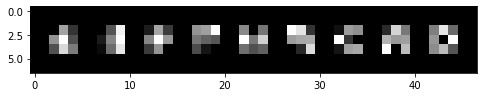

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx615/actsoftplus/lossmse/k9/bn_preTrue/model_seed0
lateral
[0.20785472 0.38252908 0.49272525 0.58193752 0.64592207 0.69200668
 0.73280597 0.77010811 0.80110324 0.82818176 0.85172711 0.86797282
 0.88285621 0.89723975 0.91076691 0.9208     0.92980775 0.93749052
 0.94471153 0.95079319]


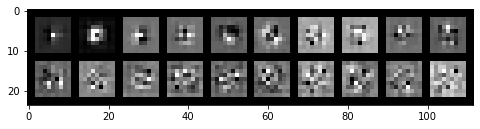

ff
[0.22074852 0.3487144  0.43455655 0.49973173 0.55752391 0.60941786
 0.64485395 0.67628597 0.70109285 0.72500953 0.7446476  0.76313941
 0.78005403 0.79562115 0.81019385 0.82366383 0.83661402 0.84810685
 0.85811778 0.86734091]


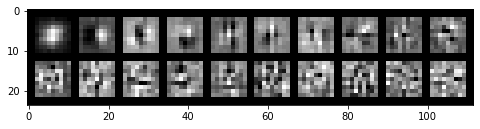

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch8/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lpoisson/m_se0, corr_norm^2 0.6243678454825125
lateral
[0.26278647 0.43688689 0.5950979  0.71262023 0.81997046 0.89029484
 0.94084937 0.98110553 1.        ]


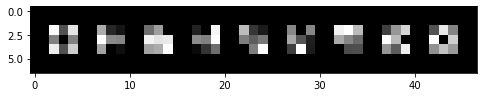

ff
[0.50952543 0.64908587 0.77836473 0.86880716 0.91454081 0.95551394
 0.97891564 0.99162542 1.        ]


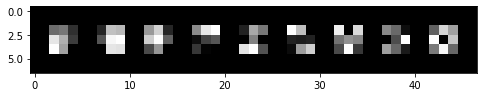

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx678/actrelu/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.34434444 0.46166165 0.54658414 0.62674234 0.68938434 0.73467956
 0.77836327 0.81217252 0.84036411 0.86054638 0.87712033 0.89027243
 0.90085417 0.91016785 0.91833669 0.9260132  0.93287449 0.93878511
 0.94366187 0.94798546]


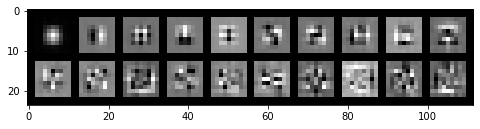

ff
[0.22539611 0.3226239  0.39750086 0.46350018 0.5133275  0.55808132
 0.59283561 0.6217451  0.64843657 0.67168826 0.69259598 0.71079526
 0.72855876 0.74489018 0.75925284 0.77242373 0.78515913 0.79744902
 0.80890195 0.81990829]


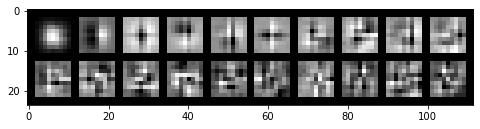

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch16/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lpoisson/m_se0, corr_norm^2 0.656582200770509
lateral
[0.32940353 0.50432879 0.66167042 0.76354613 0.85131848 0.92932515
 0.95970917 0.98384156 1.        ]


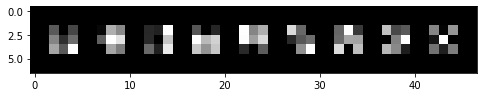

ff
[0.45950475 0.64112302 0.77041931 0.87259874 0.92525973 0.96562579
 0.97995178 0.99291736 1.        ]


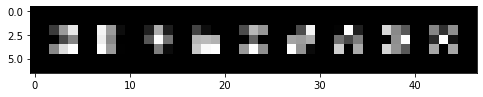

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx678/actsoftplus/lossl1/k9/bn_preTrue/model_seed0
lateral
[0.26863354 0.38557465 0.49541412 0.57883394 0.64407114 0.69364097
 0.73730666 0.77202651 0.80081361 0.82272994 0.83944011 0.85361071
 0.86736542 0.87856211 0.88866772 0.89734245 0.9055772  0.91257274
 0.91893042 0.9247823 ]


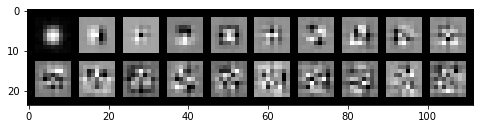

ff
[0.2361958  0.32588571 0.40990614 0.46924232 0.52028809 0.56536351
 0.59801754 0.62445456 0.6504062  0.67460823 0.69470955 0.71334734
 0.7302286  0.74608376 0.76059367 0.77343789 0.78489519 0.79583734
 0.805702   0.815203  ]


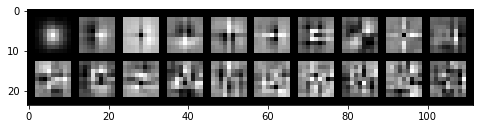

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch16/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lpoisson/m_se0, corr_norm^2 0.656582200770509
lateral
[0.32940353 0.50432879 0.66167042 0.76354613 0.85131848 0.92932515
 0.95970917 0.98384156 1.        ]


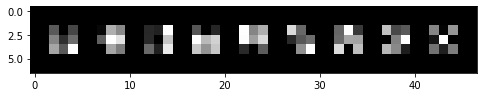

ff
[0.45950475 0.64112302 0.77041931 0.87259874 0.92525973 0.96562579
 0.97995178 0.99291736 1.        ]


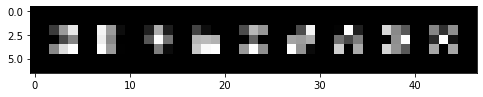

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx679/actrelu/lossl1/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.291956   0.4319364  0.52664888 0.59692083 0.65763066 0.70851524
 0.75071294 0.7830608  0.81193526 0.83737623 0.85324054 0.8683306
 0.88166017 0.89329712 0.90312393 0.91163193 0.91919417 0.92621626
 0.93244276 0.9377494 ]


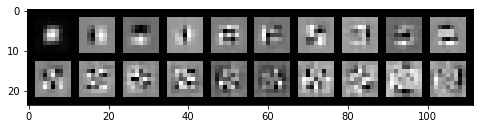

ff
[0.2064421  0.31171246 0.39106112 0.45066103 0.49493906 0.53424296
 0.56918484 0.600466   0.62902671 0.65391615 0.67458592 0.69480416
 0.71487427 0.73144503 0.74655368 0.76089696 0.77446263 0.78745502
 0.79949691 0.81059416]


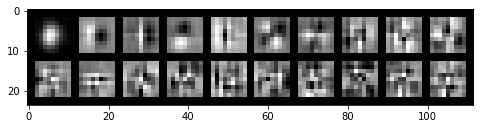

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch16/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lpoisson/m_se0, corr_norm^2 0.659025185289284
lateral
[0.28775751 0.45640854 0.60484323 0.73566245 0.83282116 0.92141474
 0.95776649 0.9853021  1.        ]


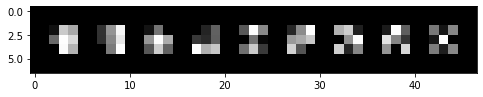

ff
[0.4373177  0.63535782 0.7536028  0.84933088 0.90332109 0.95284321
 0.97416164 0.98877654 1.        ]


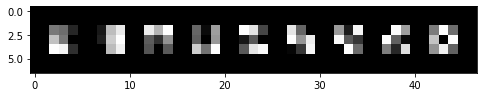

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx742/actrelu/lossmse/k9/bn_preTrue/model_seed0
lateral
[0.24678183 0.36325368 0.44447898 0.5213861  0.57688813 0.6201502
 0.66171573 0.69978375 0.73390772 0.75517659 0.77443431 0.79205141
 0.80875912 0.82279648 0.83330066 0.84340694 0.85324771 0.8625983
 0.87094334 0.87867709]


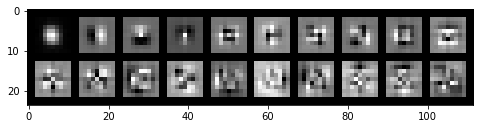

ff
[0.21893518 0.31757312 0.38696475 0.43569018 0.47950033 0.51125324
 0.54255138 0.57313818 0.59548198 0.61635532 0.63654914 0.65463424
 0.67134018 0.68618054 0.69956792 0.71193409 0.72386422 0.7353659
 0.74553366 0.75528894]


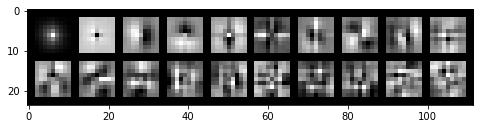

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch32/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lpoisson/m_se0, corr_norm^2 0.6817130036989621
lateral
[0.34537958 0.53295972 0.66661143 0.79113177 0.87535763 0.94654229
 0.96857847 0.9867671  1.        ]


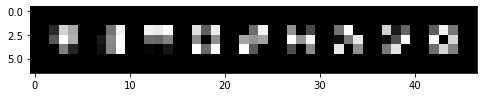

ff
[0.4104296  0.59764447 0.74170988 0.85482858 0.91000535 0.95594761
 0.97484488 0.98968989 1.        ]


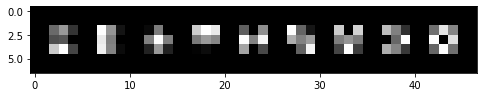

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx742/actsoftplus/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.31715072 0.44547169 0.53299635 0.5986093  0.65001627 0.69257228
 0.73253528 0.76979635 0.80289246 0.82369331 0.84157557 0.85546161
 0.86750436 0.87718639 0.88617993 0.89469071 0.90264756 0.90970788
 0.91586456 0.92185564]


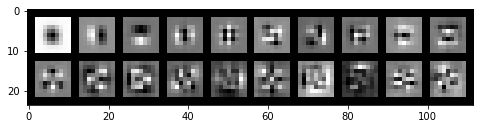

ff
[0.19271242 0.27969872 0.35375576 0.4132246  0.45509312 0.49310965
 0.52988116 0.5593108  0.58495908 0.60790022 0.62858708 0.64744783
 0.66538518 0.68205903 0.69833377 0.71342809 0.72727869 0.74020337
 0.75230697 0.76373408]


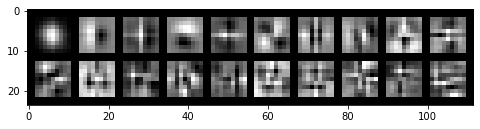

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch32/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lpoisson/m_se0, corr_norm^2 0.6817130036989621
lateral
[0.34537958 0.53295972 0.66661143 0.79113177 0.87535763 0.94654229
 0.96857847 0.9867671  1.        ]


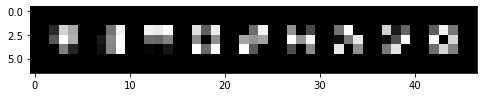

ff
[0.4104296  0.59764447 0.74170988 0.85482858 0.91000535 0.95594761
 0.97484488 0.98968989 1.        ]


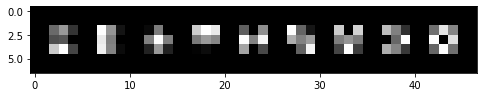

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx743/actrelu/lossl1/k9/bn_preTrue/model_seed0
lateral
[0.28724876 0.41201572 0.49448651 0.56953915 0.6227445  0.66035706
 0.69440322 0.7272082  0.75258756 0.77339865 0.79001429 0.80579575
 0.81978241 0.83307574 0.84378492 0.85391384 0.86307971 0.87125204
 0.87838407 0.8851247 ]


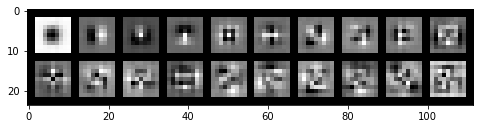

ff
[0.20095973 0.28037879 0.35606814 0.40762159 0.45563315 0.49140988
 0.52488979 0.55353404 0.57984418 0.60102022 0.62026728 0.6382082
 0.65567934 0.67195834 0.68608193 0.69974017 0.71211931 0.72382698
 0.73467965 0.74537068]


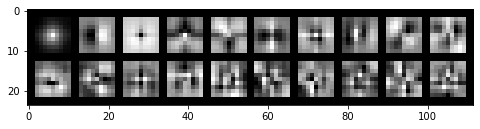

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch32/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lpoisson/m_se0, corr_norm^2 0.6719229257718388
lateral
[0.38275972 0.56243246 0.70281597 0.81515552 0.88086539 0.94080868
 0.96487965 0.98451975 1.        ]


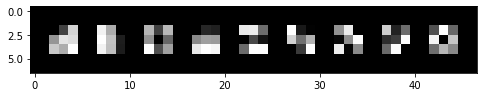

ff
[0.44778177 0.62739962 0.75260224 0.86388407 0.91260996 0.95659723
 0.97469756 0.98959794 1.        ]


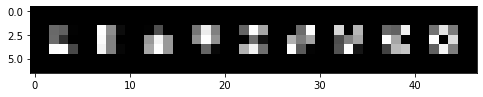

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx743/actsoftplus/lossl1/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.36432267 0.50084183 0.58443932 0.64887189 0.69928207 0.73535584
 0.77007475 0.79828191 0.82273816 0.8400913  0.85473815 0.86756095
 0.87898161 0.88844495 0.89627295 0.90329272 0.90991589 0.91588799
 0.92167947 0.92635345]


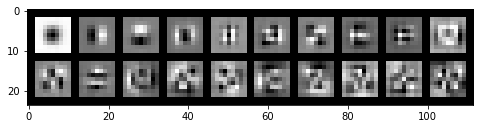

ff
[0.20712425 0.29382732 0.37534192 0.43152147 0.47649488 0.51546158
 0.54880464 0.57974473 0.6095404  0.63255748 0.65349156 0.67350706
 0.69169278 0.70846217 0.72347626 0.73725501 0.75039378 0.7623572
 0.77386222 0.78483135]


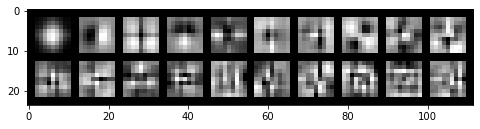

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch32/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lpoisson/m_se0, corr_norm^2 0.6719229257718388
lateral
[0.38275972 0.56243246 0.70281597 0.81515552 0.88086539 0.94080868
 0.96487965 0.98451975 1.        ]


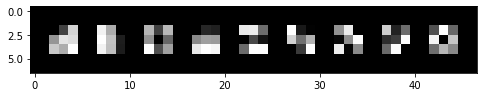

ff
[0.44778177 0.62739962 0.75260224 0.86388407 0.91260996 0.95659723
 0.97469756 0.98959794 1.        ]


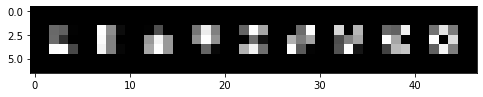

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx806/actsoftplus/lossmse/k9/bn_preTrue/model_seed0
lateral
[0.22412042 0.4032352  0.53578102 0.6255536  0.70907117 0.78006177
 0.81828995 0.84310055 0.86339893 0.88151141 0.89699218 0.90980291
 0.92153445 0.9319405  0.93995955 0.94685296 0.95336424 0.95927713
 0.96398125 0.96749753]


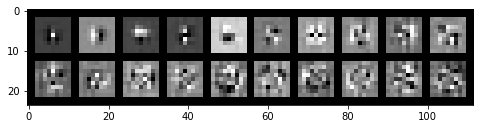

ff
[0.16534163 0.27515222 0.35014996 0.4141898  0.46715308 0.51697393
 0.55913584 0.5935018  0.62443663 0.6545935  0.68007727 0.70287512
 0.72542183 0.74567669 0.76569023 0.78358095 0.79925881 0.81320074
 0.8253748  0.83748986]


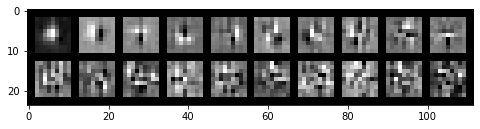

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch8/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lmse/m_se1, corr_norm^2 0.6223807696337461
lateral
[0.31047799 0.47106866 0.60976008 0.72813069 0.82928906 0.91806882
 0.95925995 0.98235382 1.        ]


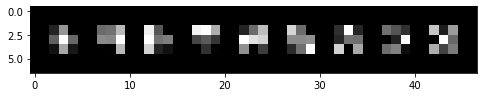

ff
[0.39848088 0.62342663 0.75786369 0.85467206 0.91663555 0.95967171
 0.9818025  0.99094451 1.        ]


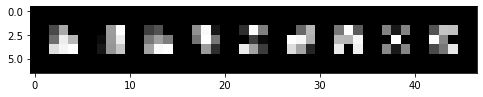

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx807/actrelu/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.22779197 0.41669209 0.55277885 0.64417705 0.71665074 0.76799777
 0.8108985  0.84255474 0.86575956 0.88464785 0.89984288 0.91151098
 0.92134104 0.9309382  0.93879743 0.94599377 0.95243477 0.9575293
 0.96218256 0.96655246]


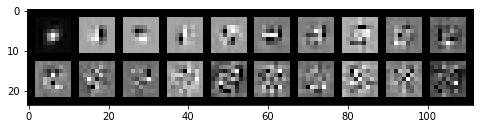

ff
[0.1467783  0.2626628  0.33451007 0.40226388 0.45972096 0.51208159
 0.55656218 0.59280827 0.62196057 0.6495497  0.67336387 0.69692732
 0.71835798 0.7376702  0.75580983 0.77234863 0.78708984 0.80119513
 0.81406117 0.82620516]


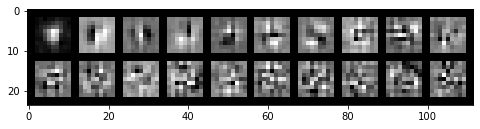

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch8/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lmse/m_se1, corr_norm^2 0.6245983468398907
lateral
[0.2594601  0.43080888 0.57896994 0.71210138 0.81848859 0.91465882
 0.96148063 0.98189208 1.        ]


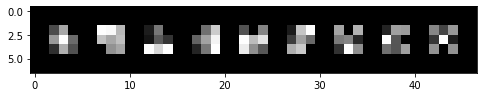

ff
[0.44774537 0.63829797 0.76099633 0.85279153 0.92337236 0.96547781
 0.98144556 0.9933791  1.        ]


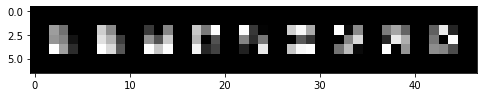

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx807/actsoftplus/lossl1/k9/bn_preTrue/model_seed0
lateral
[0.19413578 0.3288715  0.44848571 0.54924931 0.62563479 0.68645958
 0.74225867 0.77567886 0.80421883 0.82739387 0.84804315 0.86642618
 0.88357533 0.89987664 0.91130745 0.9211012  0.92967381 0.93768526
 0.94498528 0.95067212]


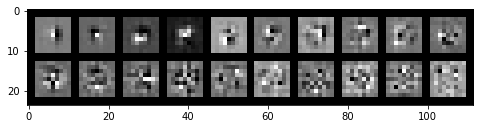

ff
[0.18487161 0.28601097 0.36738208 0.4304132  0.48450131 0.53719454
 0.57345168 0.60709131 0.63692453 0.66280658 0.68780966 0.71132864
 0.73311423 0.75250273 0.76906145 0.78502757 0.80003743 0.81415338
 0.82643323 0.83744344]


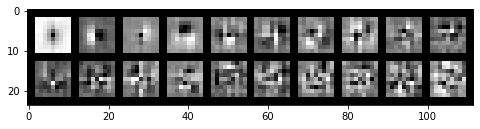

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch8/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lmse/m_se1, corr_norm^2 0.6245983468398907
lateral
[0.2594601  0.43080888 0.57896994 0.71210138 0.81848859 0.91465882
 0.96148063 0.98189208 1.        ]


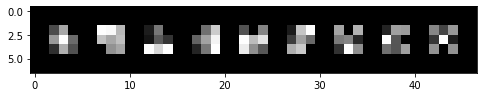

ff
[0.44774537 0.63829797 0.76099633 0.85279153 0.92337236 0.96547781
 0.98144556 0.9933791  1.        ]


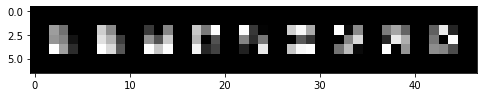

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx870/actrelu/lossl1/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.34464507 0.52561486 0.63545691 0.71655585 0.76330818 0.79671004
 0.82895138 0.85379605 0.87121816 0.88448565 0.89654644 0.90772986
 0.91709215 0.92475068 0.93176489 0.93776613 0.94323236 0.94858181
 0.95310024 0.95732116]


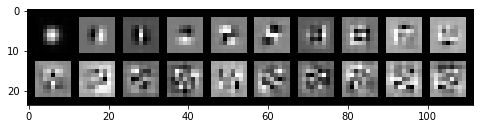

ff
[0.17907642 0.27833282 0.36289853 0.42554385 0.47820757 0.52310836
 0.563422   0.59810288 0.62797532 0.65243335 0.67446298 0.69449182
 0.71238473 0.72955262 0.74540426 0.76006292 0.77353363 0.78552646
 0.79711711 0.80840172]


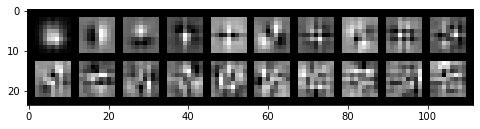

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch16/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lmse/m_se1, corr_norm^2 0.6520756769325996
lateral
[0.27821278 0.48126187 0.66480355 0.77428073 0.85723976 0.9341018
 0.96078508 0.98369457 1.        ]


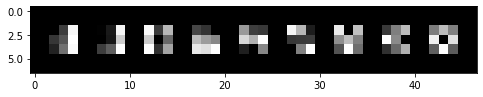

ff
[0.37385147 0.59325196 0.72170156 0.8265773  0.89342144 0.94702375
 0.96948833 0.98684472 1.        ]


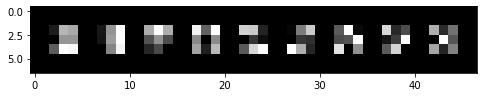

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx871/actrelu/lossmse/k9/bn_preTrue/model_seed0
lateral
[0.28080582 0.43274736 0.54623925 0.63740598 0.6874739  0.72761
 0.76021786 0.787784   0.81146117 0.82830796 0.8439363  0.85759077
 0.86894252 0.87946464 0.88886503 0.89740653 0.90508984 0.9121239
 0.918155   0.92380867]


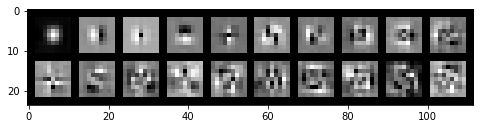

ff
[0.22188611 0.31662945 0.40582254 0.45794166 0.50277507 0.54392214
 0.58161215 0.61435375 0.63775026 0.66075446 0.68207795 0.70247474
 0.7209928  0.73839934 0.75363507 0.76801917 0.78068601 0.7926832
 0.80363706 0.81428458]


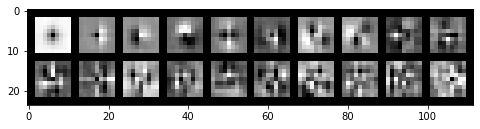

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch16/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lmse/m_se1, corr_norm^2 0.6482644130362523
lateral
[0.31864011 0.49959416 0.6684249  0.78917185 0.87059037 0.93999934
 0.96305195 0.98374311 1.        ]


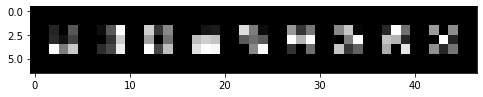

ff
[0.40651027 0.62469037 0.73099534 0.83020926 0.89472729 0.94594917
 0.96851778 0.98832448 1.        ]


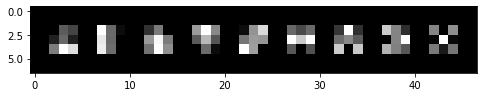

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx871/actsoftplus/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.36918188 0.55001738 0.64952415 0.73968797 0.77927174 0.8103241
 0.83367971 0.85465085 0.87343985 0.88577369 0.89716049 0.90741151
 0.9156024  0.92262592 0.92886636 0.93443943 0.93965104 0.94413017
 0.94836999 0.9522588 ]


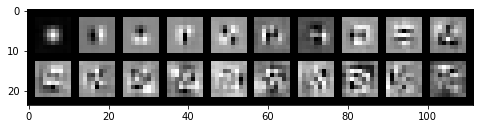

ff
[0.1868079  0.29243843 0.37014826 0.42694744 0.47285215 0.51627158
 0.55699651 0.59338314 0.62040215 0.64694192 0.67091853 0.69207704
 0.71244242 0.73043523 0.74650532 0.76149887 0.77512677 0.78680061
 0.79818964 0.80922445]


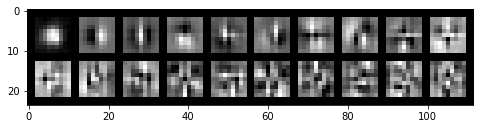

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch16/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lmse/m_se1, corr_norm^2 0.6482644130362523
lateral
[0.31864011 0.49959416 0.6684249  0.78917185 0.87059037 0.93999934
 0.96305195 0.98374311 1.        ]


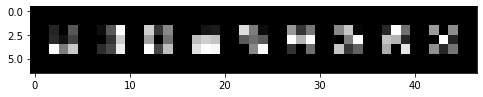

ff
[0.40651027 0.62469037 0.73099534 0.83020926 0.89472729 0.94594917
 0.96851778 0.98832448 1.        ]


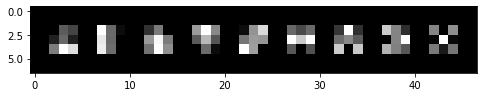

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx934/actrelu/lossl1/k9/bn_preTrue/model_seed0
lateral
[0.31831687 0.46880412 0.54437914 0.61603929 0.65430378 0.68820002
 0.71728932 0.74324097 0.7621348  0.77859062 0.79129778 0.80315955
 0.81463382 0.82542403 0.8356154  0.84456726 0.85257544 0.85986895
 0.86656482 0.87266559]


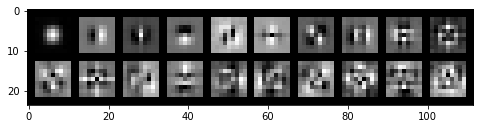

ff
[0.20678194 0.30940497 0.39510003 0.45126626 0.49956336 0.53442111
 0.56724171 0.59569752 0.6184305  0.63715887 0.65527049 0.6720774
 0.6883194  0.70392809 0.71742021 0.72966064 0.74097131 0.75093006
 0.76081391 0.7705531 ]


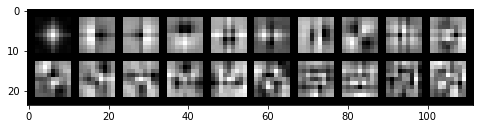

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch32/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lmse/m_se1, corr_norm^2 0.6721479868699023
lateral
[0.3555398  0.55659511 0.69341002 0.81213067 0.88123899 0.93703195
 0.96018292 0.980968   1.        ]


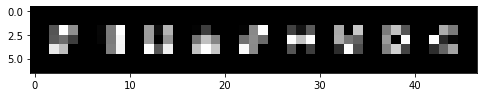

ff
[0.38606296 0.61008547 0.7393922  0.83338182 0.88738995 0.93527593
 0.96442938 0.98347956 1.        ]


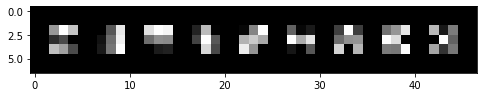

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx934/actsoftplus/lossl1/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.38861888 0.55770942 0.63969362 0.70988643 0.74479975 0.77644233
 0.80369591 0.82782744 0.84162075 0.8541177  0.86588559 0.87656156
 0.88613483 0.89479201 0.90265059 0.91018313 0.91646372 0.92155552
 0.92656471 0.9309516 ]


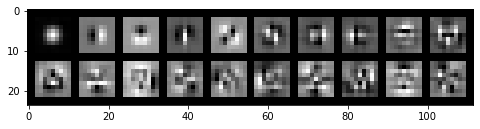

ff
[0.20139738 0.30814938 0.37506441 0.4367069  0.47957435 0.52150339
 0.56026079 0.59431863 0.61966493 0.64295401 0.66500328 0.68462764
 0.70308006 0.72004641 0.73523506 0.74939126 0.76130467 0.77292725
 0.78344231 0.79386209]


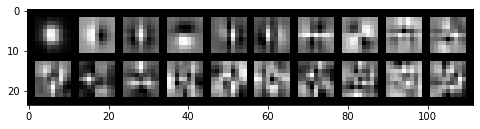

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch32/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lmse/m_se1, corr_norm^2 0.6721479868699023
lateral
[0.3555398  0.55659511 0.69341002 0.81213067 0.88123899 0.93703195
 0.96018292 0.980968   1.        ]


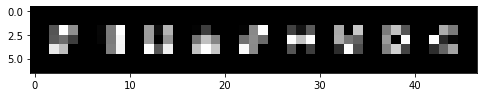

ff
[0.38606296 0.61008547 0.7393922  0.83338182 0.88738995 0.93527593
 0.96442938 0.98347956 1.        ]


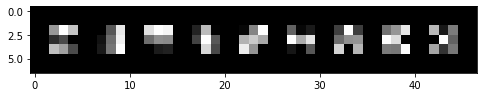

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx935/actsoftplus/lossmse/k9/bn_preTrue/model_seed0
lateral
[0.28916703 0.42135397 0.50431711 0.58315858 0.62486846 0.66329099
 0.69667491 0.72591318 0.74912948 0.76721687 0.78373747 0.79926893
 0.81425353 0.82694177 0.8389754  0.85034482 0.85991745 0.86842042
 0.87615076 0.88337029]


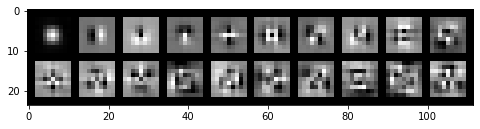

ff
[0.21222325 0.32508591 0.39943193 0.45732193 0.49559792 0.53106781
 0.56408154 0.5918948  0.61520229 0.63545117 0.65495467 0.67377609
 0.69141786 0.70802046 0.72268503 0.73493767 0.7470736  0.75797984
 0.76847805 0.77814645]


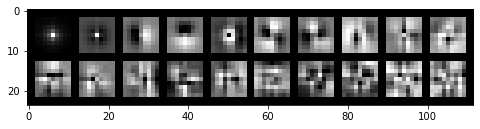

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch32/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lmse/m_se1, corr_norm^2 0.6714271572978623
lateral
[0.36514296 0.55983562 0.69739989 0.82286881 0.88261506 0.93925731
 0.96099147 0.98227475 1.        ]


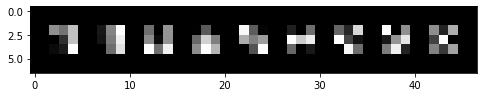

ff
[0.40201801 0.61053588 0.74437901 0.83348672 0.88859029 0.93893276
 0.96472773 0.98306151 1.        ]


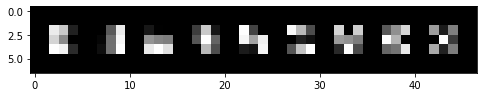

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx998/actrelu/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.28066397 0.45190746 0.58977969 0.67859207 0.7641765  0.82232905
 0.85163831 0.874112   0.89144503 0.90729591 0.92046965 0.93070645
 0.93876009 0.94628528 0.95224863 0.95806495 0.96318038 0.96764628
 0.97196034 0.9756386 ]


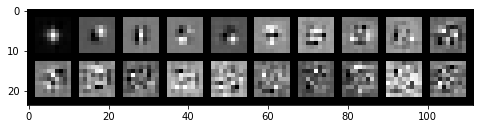

ff
[0.17536733 0.28269214 0.35944068 0.42959104 0.48429645 0.53521517
 0.57635604 0.61308529 0.64797292 0.67635183 0.7007145  0.72268457
 0.74357409 0.76079419 0.77711462 0.79198307 0.8047683  0.81741551
 0.82963608 0.84095962]


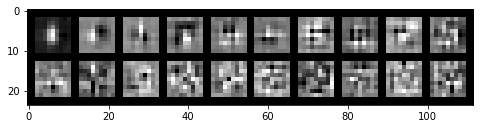

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch8/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lpoisson/m_se1, corr_norm^2 0.6142176850084105
lateral
[0.29523279 0.47922695 0.62143969 0.73105808 0.83868302 0.9187083
 0.95505727 0.98489538 1.        ]


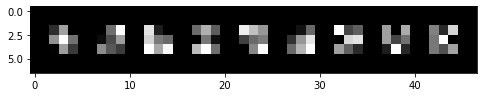

ff
[0.39105748 0.58902601 0.73876544 0.83275843 0.90534833 0.95143921
 0.97568749 0.9898844  1.        ]


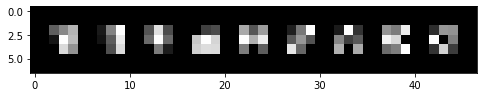

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx998/actsoftplus/lossl1/k9/bn_preTrue/model_seed0
lateral
[0.22134186 0.38102708 0.50468249 0.58946869 0.67171753 0.73425469
 0.78052416 0.81532046 0.84090497 0.86092796 0.87860746 0.89324937
 0.90741104 0.91999772 0.92876983 0.93649162 0.94270769 0.94862094
 0.95410118 0.9591291 ]


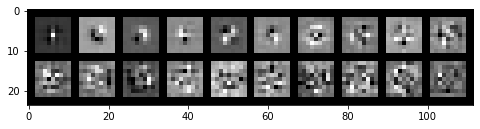

ff
[0.18172937 0.27164712 0.34890793 0.41630204 0.469995   0.51230803
 0.55234055 0.58840632 0.62155783 0.64987249 0.67752724 0.70257394
 0.72419979 0.74438099 0.76415041 0.78072132 0.79538437 0.80919097
 0.82153586 0.83351409]


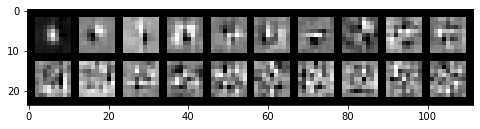

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch8/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lpoisson/m_se1, corr_norm^2 0.6142176850084105
lateral
[0.29523279 0.47922695 0.62143969 0.73105808 0.83868302 0.9187083
 0.95505727 0.98489538 1.        ]


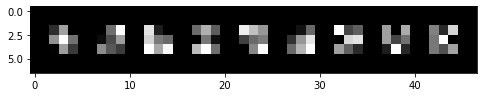

ff
[0.39105748 0.58902601 0.73876544 0.83275843 0.90534833 0.95143921
 0.97568749 0.9898844  1.        ]


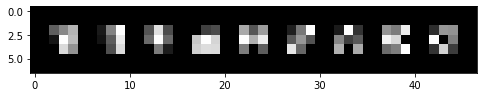

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx999/actrelu/lossl1/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.3294158  0.51074162 0.6335685  0.72659817 0.78349459 0.82120025
 0.85140862 0.87897913 0.9011312  0.91752776 0.93020965 0.94088777
 0.94792938 0.95399059 0.95959458 0.96509145 0.9693887  0.97300729
 0.97626132 0.97895877]


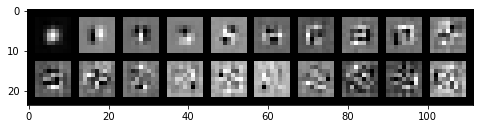

ff
[0.19608961 0.32150096 0.40843166 0.48231563 0.54096612 0.5917291
 0.63030315 0.66688558 0.6982691  0.72724575 0.75417465 0.77355716
 0.7923583  0.80876064 0.82340022 0.83697567 0.84984882 0.8613525
 0.87177486 0.88132997]


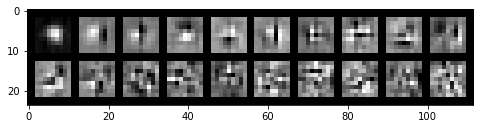

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch8/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lpoisson/m_se1, corr_norm^2 0.6166026041489062
lateral
[0.25487896 0.45936804 0.62840173 0.741078   0.84340675 0.92762598
 0.96107183 0.9853853  1.        ]


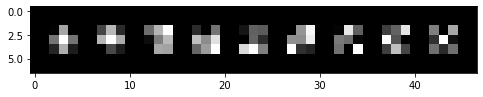

ff
[0.4079421  0.61693634 0.7553161  0.83590695 0.90637454 0.96044216
 0.98073777 0.99453269 1.        ]


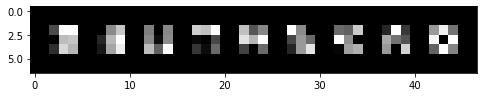

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx1062/actrelu/lossmse/k9/bn_preTrue/model_seed0
lateral
[0.297591   0.44995988 0.56388007 0.64219569 0.68897429 0.73115485
 0.76356992 0.78883561 0.8125726  0.82993554 0.84571902 0.86038051
 0.87320951 0.88388917 0.89279071 0.9011343  0.90815901 0.9140576
 0.91988005 0.92528335]


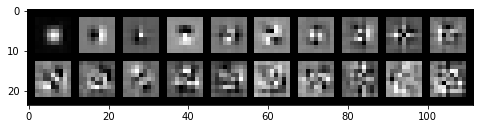

ff
[0.23290296 0.34352195 0.43905796 0.49364706 0.54038012 0.57718058
 0.61096925 0.6438625  0.67070075 0.69348972 0.71362126 0.73257103
 0.75057371 0.76699914 0.78141315 0.79441001 0.80632719 0.81714305
 0.8276972  0.83709528]


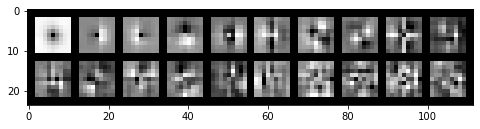

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch16/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lpoisson/m_se1, corr_norm^2 0.650769979902205
lateral
[0.34874049 0.53921162 0.68175759 0.80107269 0.87006737 0.93173962
 0.95801666 0.98041532 1.        ]


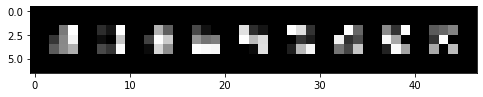

ff
[0.43193572 0.63326519 0.752374   0.8245834  0.89052146 0.94608003
 0.96728962 0.98536265 1.        ]


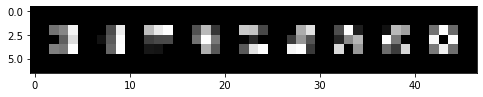

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx1062/actsoftplus/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.41366011 0.57506959 0.66963425 0.74609916 0.79008648 0.81966847
 0.8443872  0.86288267 0.87907746 0.89162267 0.9023276  0.91168464
 0.92026358 0.92722029 0.93280824 0.93804123 0.94314151 0.94708366
 0.95084335 0.95437826]


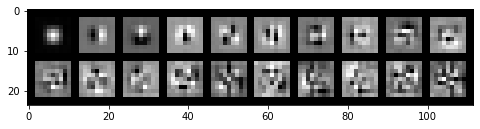

ff
[0.2109818  0.32790224 0.40001519 0.4679838  0.52215073 0.56112851
 0.59748921 0.6303184  0.65647062 0.68130489 0.70353325 0.72355258
 0.7417011  0.75740667 0.77174372 0.78580106 0.79791664 0.809688
 0.82015371 0.83017227]


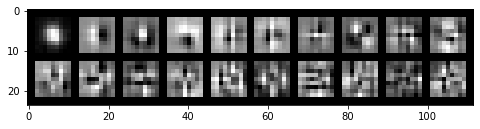

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch16/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lpoisson/m_se1, corr_norm^2 0.650769979902205
lateral
[0.34874049 0.53921162 0.68175759 0.80107269 0.87006737 0.93173962
 0.95801666 0.98041532 1.        ]


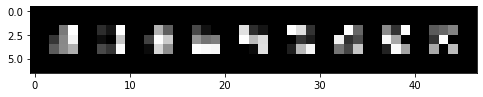

ff
[0.43193572 0.63326519 0.752374   0.8245834  0.89052146 0.94608003
 0.96728962 0.98536265 1.        ]


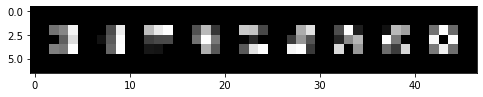

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx1063/actrelu/lossl1/k9/bn_preTrue/model_seed0
lateral
[0.23567918 0.36499897 0.44717573 0.51940542 0.56743717 0.60611534
 0.63382673 0.65785237 0.68090358 0.69961212 0.71508896 0.7297991
 0.74317826 0.75528575 0.7665946  0.77773623 0.78834112 0.79802048
 0.80696868 0.81574373]


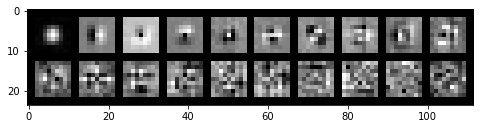

ff
[0.24764939 0.34712933 0.41714064 0.4691775  0.52042688 0.55464659
 0.58392563 0.6120398  0.63353136 0.65368681 0.67231395 0.6893331
 0.70474479 0.71950658 0.73319034 0.74522566 0.75648556 0.76671399
 0.77607905 0.78513776]


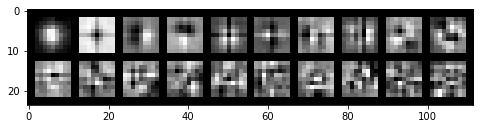

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch16/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lpoisson/m_se1, corr_norm^2 0.6528172758966946
lateral
[0.31198199 0.50086769 0.66512303 0.77614257 0.86021455 0.93411829
 0.96133233 0.98269465 1.        ]


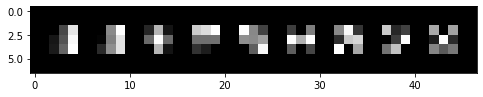

ff
[0.43630105 0.66104803 0.76048626 0.85282007 0.91075056 0.9556348
 0.97434095 0.98809148 1.        ]


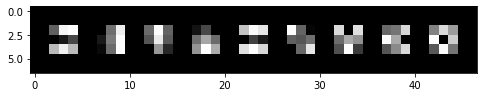

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx1063/actsoftplus/lossl1/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.36978085 0.54332803 0.63980863 0.71424457 0.75282477 0.7895489
 0.82107304 0.84673291 0.86893158 0.88099043 0.89243048 0.90313047
 0.91146486 0.91965174 0.92632041 0.93257098 0.93758297 0.9421135
 0.9464323  0.95047182]


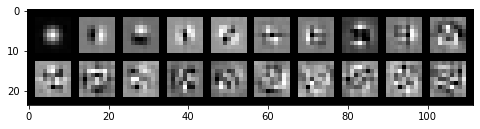

ff
[0.22325157 0.32341884 0.39881499 0.47236906 0.52375966 0.56622253
 0.60081108 0.63169087 0.65876654 0.6815314  0.70293324 0.72334244
 0.74138983 0.75824268 0.77283974 0.7856568  0.79747493 0.80896557
 0.81944821 0.82972073]


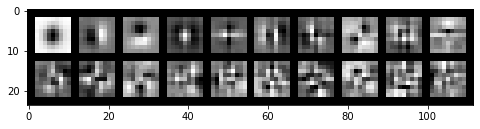

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch16/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lpoisson/m_se1, corr_norm^2 0.6528172758966946
lateral
[0.31198199 0.50086769 0.66512303 0.77614257 0.86021455 0.93411829
 0.96133233 0.98269465 1.        ]


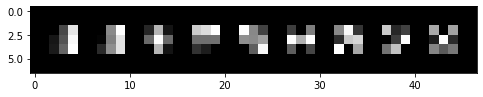

ff
[0.43630105 0.66104803 0.76048626 0.85282007 0.91075056 0.9556348
 0.97434095 0.98809148 1.        ]


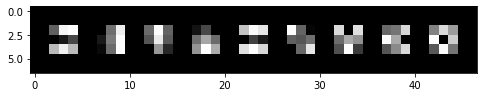

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx1126/actsoftplus/lossmse/k9/bn_preTrue/model_seed0
lateral
[0.27950236 0.41037743 0.49172341 0.5621972  0.61174556 0.64972375
 0.6823281  0.71075224 0.73283485 0.75206147 0.77032877 0.78748236
 0.8033969  0.8185429  0.83089478 0.84172702 0.85135793 0.85982917
 0.86812748 0.87533763]


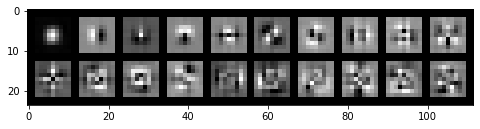

ff
[0.22042024 0.32486747 0.39646189 0.45216776 0.49320786 0.5255944
 0.55644728 0.58516781 0.61201934 0.63223014 0.65148396 0.66963346
 0.68753316 0.70308552 0.71677868 0.72936311 0.74102542 0.75228745
 0.76266202 0.77236497]


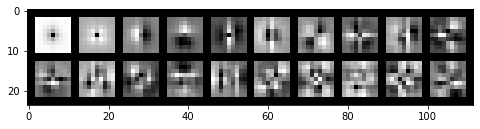

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch32/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lpoisson/m_se1, corr_norm^2 0.6773248491585808
lateral
[0.39769969 0.59141765 0.72371773 0.83077963 0.8887002  0.94173164
 0.96398723 0.98304923 1.        ]


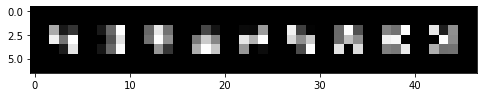

ff
[0.40848225 0.63611636 0.76176774 0.8451595  0.90233373 0.94837919
 0.96822796 0.98612195 1.        ]


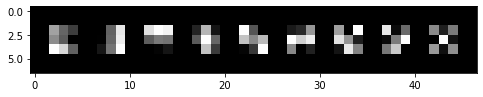

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx1127/actrelu/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.40216169 0.54464101 0.62894148 0.70114291 0.74023157 0.77101798
 0.79860109 0.82094368 0.83570272 0.84918965 0.86027805 0.87048941
 0.88029107 0.8885592  0.89562908 0.90256449 0.90829886 0.91395278
 0.91940016 0.92439859]


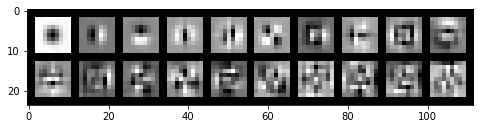

ff
[0.2250181  0.3189475  0.3984112  0.45857219 0.49705637 0.53411983
 0.5669059  0.59586086 0.62048383 0.64295415 0.66310418 0.682367
 0.69930062 0.71550159 0.72988236 0.74170463 0.75323529 0.76412427
 0.77386876 0.78283449]


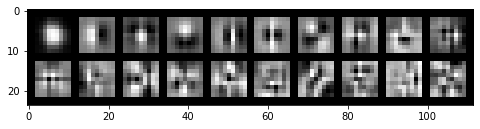

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch32/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lpoisson/m_se1, corr_norm^2 0.6677939357363986
lateral
[0.41156133 0.58769093 0.71536774 0.82198401 0.88073795 0.93319129
 0.95678179 0.97902204 1.        ]


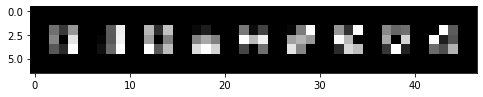

ff
[0.43650065 0.64268943 0.76370812 0.83902858 0.89081563 0.93624588
 0.96002753 0.98010565 1.        ]


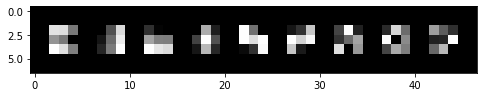

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx1127/actsoftplus/lossl1/k9/bn_preTrue/model_seed0
lateral
[0.28778931 0.39877148 0.48759408 0.55443148 0.60671704 0.64797857
 0.67766205 0.70539682 0.7287596  0.74889189 0.7665246  0.78202596
 0.79481461 0.80650378 0.81728839 0.82715807 0.83625023 0.84438364
 0.85207629 0.85920451]


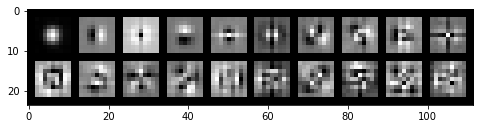

ff
[0.27983124 0.36866591 0.43650621 0.48491929 0.52089196 0.55152831
 0.57842501 0.60376136 0.62818221 0.64781484 0.66539716 0.68230128
 0.6982801  0.71280241 0.72720335 0.73938207 0.75019631 0.75989683
 0.76865633 0.77681381]


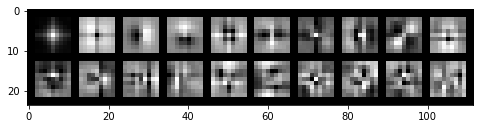

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch32/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lpoisson/m_se1, corr_norm^2 0.6677939357363986
lateral
[0.41156133 0.58769093 0.71536774 0.82198401 0.88073795 0.93319129
 0.95678179 0.97902204 1.        ]


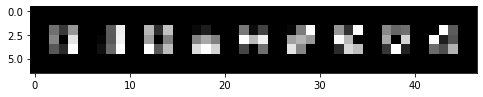

ff
[0.43650065 0.64268943 0.76370812 0.83902858 0.89081563 0.93624588
 0.96002753 0.98010565 1.        ]


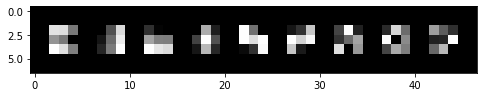

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx1190/actrelu/lossl1/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.29170257 0.42953078 0.53784548 0.62826625 0.69079035 0.74679403
 0.7946795  0.82924787 0.85735333 0.88179879 0.89888344 0.91195176
 0.92363941 0.93495022 0.94331766 0.95133274 0.95775882 0.96281679
 0.96748197 0.97153393]


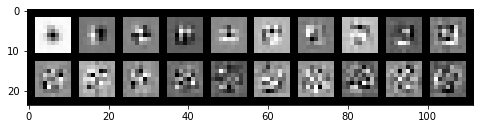

ff
[0.24704723 0.35960189 0.43424905 0.49522134 0.54902799 0.59834064
 0.63196823 0.66387692 0.69164843 0.71736691 0.74029092 0.7579911
 0.77542203 0.79143179 0.80654775 0.82035955 0.8328723  0.84449505
 0.85546004 0.86534738]


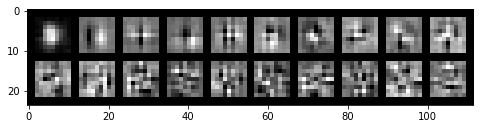

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch8/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lmse/m_se1, corr_norm^2 0.5997784961429065
lateral
[0.22637749 0.42734432 0.59647385 0.74240539 0.82920979 0.90883051
 0.95579554 0.98228673 1.        ]


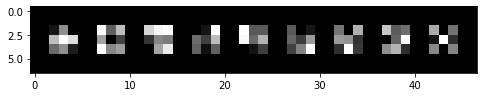

ff
[0.51082037 0.71172456 0.82224705 0.88484432 0.93538875 0.96543629
 0.98631723 0.99542744 1.        ]


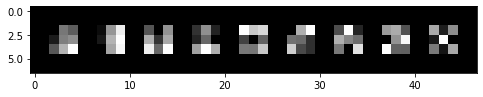

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx1191/actrelu/lossmse/k9/bn_preTrue/model_seed0
lateral
[0.16913342 0.30780541 0.42387057 0.5271388  0.62010489 0.68297433
 0.73255574 0.7712376  0.80416283 0.83418467 0.85738159 0.87704309
 0.89314276 0.90735536 0.92024527 0.93206317 0.94182257 0.94953687
 0.95677298 0.9617779 ]


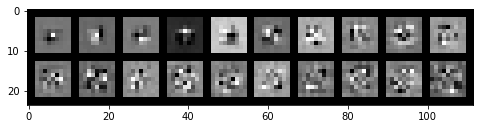

ff
[0.19431502 0.28375892 0.35049477 0.41396745 0.46299435 0.51013845
 0.55424853 0.59353574 0.62356424 0.65095779 0.67528429 0.69828169
 0.71864082 0.73783607 0.75621937 0.77321582 0.78887235 0.80337312
 0.81682086 0.82886869]


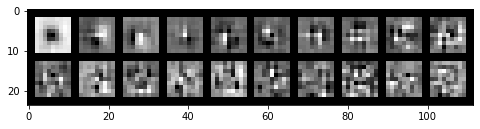

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch8/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lmse/m_se1, corr_norm^2 0.6094166336129911
lateral
[0.18756236 0.36146509 0.53319503 0.68321957 0.7950863  0.8967106
 0.949679   0.9861488  1.        ]


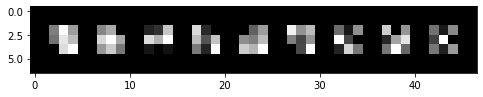

ff
[0.49255121 0.64420204 0.77507341 0.87832791 0.92600861 0.96700031
 0.98342759 0.99435884 1.        ]


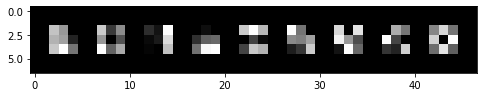

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx1191/actsoftplus/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.20026629 0.34165357 0.46681984 0.57013702 0.65954496 0.72093601
 0.76323866 0.80212908 0.8330086  0.85704143 0.87920386 0.89651995
 0.91202223 0.92418759 0.9352461  0.94533215 0.95334032 0.96014593
 0.96562748 0.97010825]


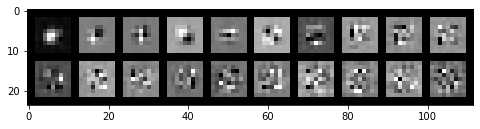

ff
[0.18149233 0.28140266 0.35174008 0.41071332 0.46572265 0.51243864
 0.55413187 0.59126262 0.62297005 0.65210704 0.67733966 0.70021334
 0.72180263 0.74016819 0.75707936 0.77342986 0.7888364  0.80307476
 0.81616809 0.82849573]


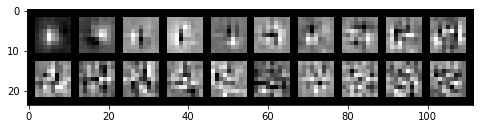

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch8/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lmse/m_se1, corr_norm^2 0.6094166336129911
lateral
[0.18756236 0.36146509 0.53319503 0.68321957 0.7950863  0.8967106
 0.949679   0.9861488  1.        ]


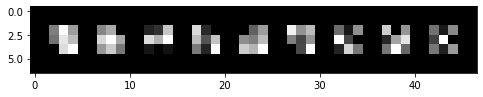

ff
[0.49255121 0.64420204 0.77507341 0.87832791 0.92600861 0.96700031
 0.98342759 0.99435884 1.        ]


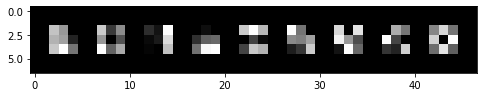

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx1254/actrelu/lossl1/k9/bn_preTrue/model_seed0
lateral
[0.28908618 0.41140719 0.51661138 0.59430817 0.65065681 0.69558548
 0.73333024 0.7640805  0.79065856 0.81436726 0.83139966 0.84706275
 0.85954025 0.87137898 0.88114028 0.89067362 0.89865848 0.90619743
 0.91280471 0.91861663]


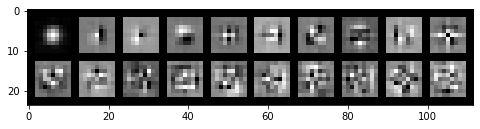

ff
[0.215143   0.3011448  0.38234419 0.45321311 0.50166496 0.54557403
 0.58076396 0.61144805 0.63636272 0.66055093 0.68203241 0.70279434
 0.72176909 0.73990139 0.75477258 0.76801957 0.78026156 0.79169873
 0.80202287 0.81182587]


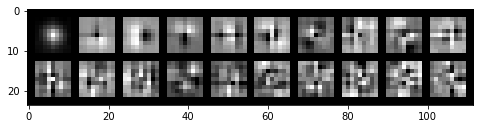

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch16/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lmse/m_se1, corr_norm^2 0.6446164372350426
lateral
[0.33880292 0.5137913  0.67505052 0.78022268 0.87541722 0.94533514
 0.9679156  0.98726709 1.        ]


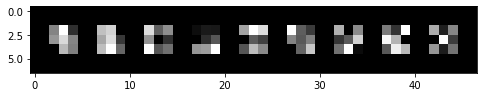

ff
[0.46605399 0.64564797 0.76971224 0.88087996 0.92999566 0.96796723
 0.98095456 0.99201946 1.        ]


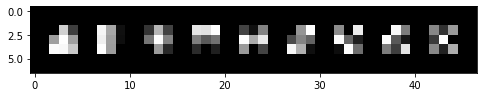

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx1254/actsoftplus/lossl1/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.35736052 0.49134378 0.57429536 0.65492376 0.70897074 0.74961078
 0.7850137  0.81359489 0.84043939 0.85722369 0.87216493 0.88589054
 0.89683694 0.9071191  0.9150184  0.9225535  0.92888176 0.93440789
 0.93957968 0.94432054]


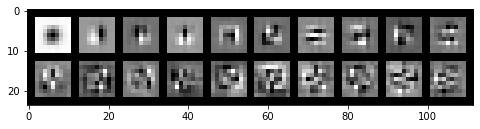

ff
[0.22215388 0.3121138  0.3956563  0.45987013 0.50930608 0.55715043
 0.5975854  0.63145495 0.66105051 0.68527381 0.70737065 0.72728147
 0.74476182 0.76187767 0.77700355 0.79086534 0.80313542 0.81385269
 0.82343803 0.8324308 ]


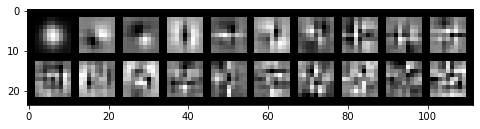

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch16/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lmse/m_se1, corr_norm^2 0.6446164372350426
lateral
[0.33880292 0.5137913  0.67505052 0.78022268 0.87541722 0.94533514
 0.9679156  0.98726709 1.        ]


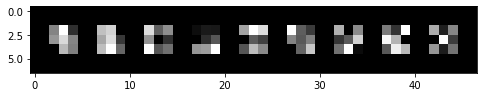

ff
[0.46605399 0.64564797 0.76971224 0.88087996 0.92999566 0.96796723
 0.98095456 0.99201946 1.        ]


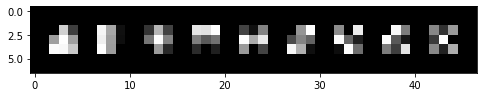

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx1255/actsoftplus/lossmse/k9/bn_preTrue/model_seed0
lateral
[0.22519918 0.35122618 0.45645601 0.53632565 0.60329881 0.65770758
 0.69907003 0.73702484 0.76889253 0.78890353 0.80743754 0.82521939
 0.84066888 0.85503771 0.86688323 0.87757639 0.88579676 0.89383674
 0.9014074  0.90869143]


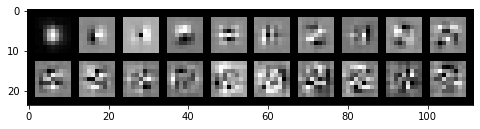

ff
[0.22606211 0.31270408 0.37982909 0.4415541  0.4903756  0.52848997
 0.56138467 0.59066804 0.61610326 0.63972195 0.66141284 0.6801511
 0.69744956 0.71397023 0.72928548 0.74289676 0.75608227 0.76865874
 0.77993098 0.78993941]


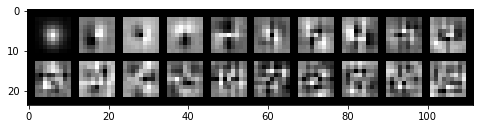

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch16/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lmse/m_se1, corr_norm^2 0.6466639993324228
lateral
[0.2905034  0.47022887 0.6407037  0.75709986 0.8663845  0.9394348
 0.96365528 0.98374524 1.        ]


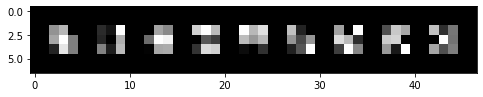

ff
[0.46962363 0.65451443 0.77271601 0.86656441 0.91827191 0.9605615
 0.97989942 0.99100364 1.        ]


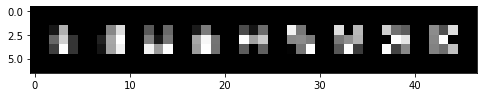

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx1318/actrelu/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.33925192 0.47340958 0.56480607 0.63116842 0.68608878 0.72178157
 0.75489722 0.78368284 0.80871455 0.82513918 0.83975734 0.85266867
 0.86323633 0.87334642 0.88201327 0.89015843 0.89764818 0.90461077
 0.91096077 0.91642709]


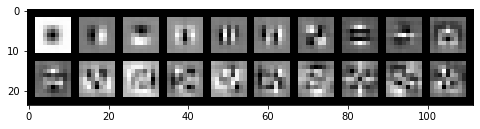

ff
[0.18245005 0.2688835  0.3409798  0.39497424 0.43862731 0.47963535
 0.5149304  0.54563251 0.57340412 0.59640148 0.61814686 0.63745134
 0.65594756 0.67302103 0.6887528  0.70294252 0.71616223 0.72875647
 0.74043447 0.75200994]


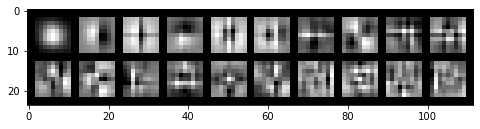

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch32/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lmse/m_se1, corr_norm^2 0.6624371123885079
lateral
[0.3875108  0.57035257 0.70123958 0.82316454 0.89511822 0.95488343
 0.97187529 0.98700284 1.        ]


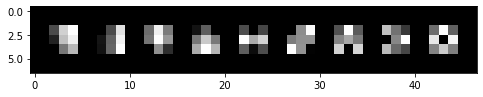

ff
[0.43052704 0.63559568 0.76424274 0.85739248 0.91311597 0.95554208
 0.97241006 0.98795355 1.        ]


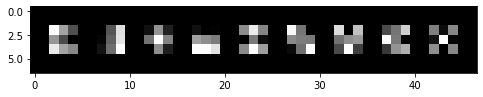

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx1318/actsoftplus/lossl1/k9/bn_preTrue/model_seed0
lateral
[0.28069248 0.3988349  0.4873811  0.56285485 0.61433746 0.65418596
 0.68751698 0.71821398 0.74693742 0.76729067 0.78422789 0.80062615
 0.81381538 0.82539667 0.83673065 0.84651444 0.85508481 0.86332229
 0.87082402 0.87761925]


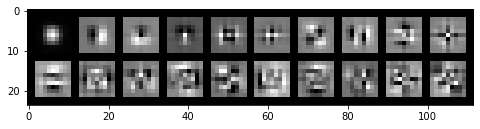

ff
[0.19078718 0.27689394 0.34983809 0.39599323 0.43805174 0.474799
 0.50741753 0.53609013 0.56193747 0.584348   0.60345032 0.62149232
 0.63882396 0.65465938 0.66971537 0.68274998 0.69527019 0.70690993
 0.71732593 0.72745386]


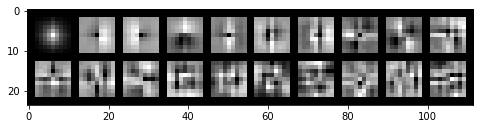

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch32/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lmse/m_se1, corr_norm^2 0.6624371123885079
lateral
[0.3875108  0.57035257 0.70123958 0.82316454 0.89511822 0.95488343
 0.97187529 0.98700284 1.        ]


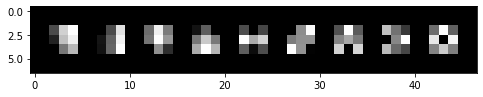

ff
[0.43052704 0.63559568 0.76424274 0.85739248 0.91311597 0.95554208
 0.97241006 0.98795355 1.        ]


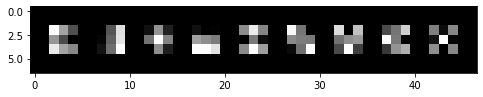

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx1319/actrelu/lossl1/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.32377758 0.47604713 0.55621104 0.63080175 0.67286415 0.70982422
 0.74249639 0.77150935 0.7992187  0.81834792 0.834976   0.84940428
 0.86355033 0.87536336 0.8842611  0.89243198 0.89998499 0.90697689
 0.91269017 0.91809726]


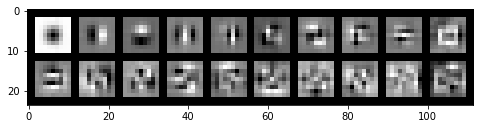

ff
[0.19275543 0.29216684 0.37421062 0.42944223 0.47820704 0.51993532
 0.55862715 0.58856879 0.61335716 0.63599311 0.65734712 0.67771748
 0.69586389 0.71234262 0.72799504 0.74148511 0.75485629 0.76738143
 0.77982392 0.79032919]


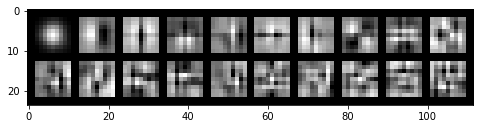

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch32/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lmse/m_se1, corr_norm^2 0.6518409597346869
lateral
[0.37416227 0.57507312 0.69902568 0.80555642 0.88721545 0.95068336
 0.97001509 0.98679601 1.        ]


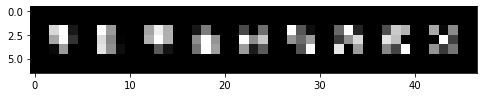

ff
[0.41057845 0.63198588 0.76016177 0.85931494 0.91608652 0.95518993
 0.97236761 0.98899805 1.        ]


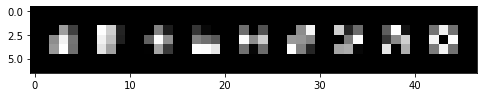

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx1382/actrelu/lossmse/k9/bn_preTrue/model_seed0
lateral
[0.17608525 0.3125437  0.42503038 0.51947067 0.59571825 0.66522508
 0.72142272 0.75917502 0.79255057 0.81968075 0.84354707 0.86386991
 0.88031788 0.89457058 0.90731562 0.91788646 0.92703441 0.93545735
 0.94274053 0.94930455]


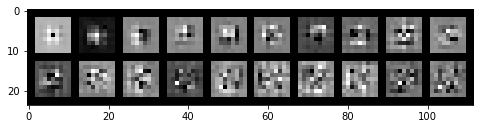

ff
[0.21289355 0.33186046 0.41931448 0.48383322 0.54015502 0.58588154
 0.62842388 0.66250878 0.69367362 0.72038903 0.74246327 0.76421803
 0.7812221  0.79802273 0.81340092 0.82727426 0.83995619 0.85168912
 0.86233619 0.8716895 ]


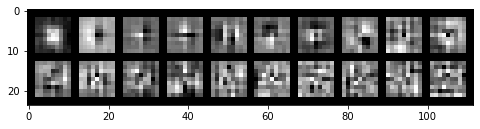

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch8/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lpoisson/m_se1, corr_norm^2 0.6217184763692263
lateral
[0.27589829 0.46149982 0.63252659 0.77780946 0.86159941 0.93475923
 0.96541378 0.98834541 1.        ]


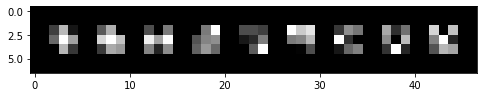

ff
[0.48002373 0.62654573 0.7598482  0.89273761 0.94401644 0.97391822
 0.98655057 0.99675668 1.        ]


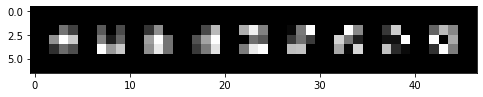

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx1382/actsoftplus/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.2520564  0.37636036 0.49143814 0.59213001 0.66286824 0.7153435
 0.76305461 0.80506231 0.83720315 0.8598855  0.88043053 0.89912018
 0.91153695 0.92242629 0.93275048 0.94184996 0.94910642 0.95535441
 0.96100581 0.96639358]


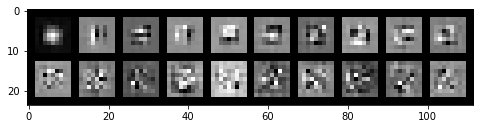

ff
[0.25842432 0.36425548 0.45815543 0.52534346 0.58146808 0.62394118
 0.66006002 0.69127565 0.71845556 0.74317859 0.76455238 0.78561204
 0.80386203 0.82030971 0.83515341 0.84897097 0.86170829 0.87350142
 0.88287587 0.89156698]


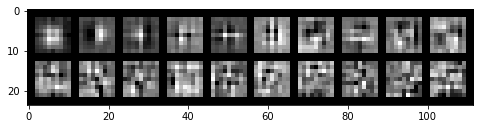

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch8/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lpoisson/m_se1, corr_norm^2 0.6217184763692263
lateral
[0.27589829 0.46149982 0.63252659 0.77780946 0.86159941 0.93475923
 0.96541378 0.98834541 1.        ]


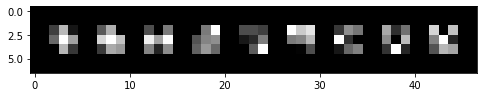

ff
[0.48002373 0.62654573 0.7598482  0.89273761 0.94401644 0.97391822
 0.98655057 0.99675668 1.        ]


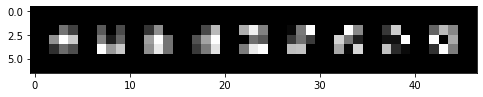

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx1383/actrelu/lossl1/k9/bn_preTrue/model_seed0
lateral
[0.29061186 0.4513422  0.55530276 0.64377562 0.70172093 0.7435799
 0.78334444 0.81423268 0.84021703 0.86428685 0.8847637  0.89824338
 0.9098105  0.91987441 0.92912629 0.93721014 0.94356815 0.94917376
 0.95417686 0.95870272]


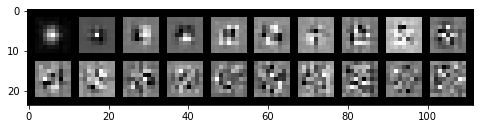

ff
[0.28862766 0.39450744 0.45512699 0.51090571 0.56205169 0.60213702
 0.63626777 0.66862408 0.69812598 0.72060106 0.74117179 0.75959425
 0.77723756 0.79346411 0.80832744 0.82163617 0.83409916 0.845997
 0.8568673  0.86722903]


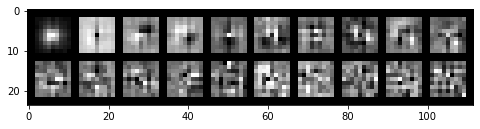

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch8/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lpoisson/m_se1, corr_norm^2 0.6057464221765619
lateral
[0.27148395 0.4894733  0.61485605 0.73543086 0.81807099 0.89932328
 0.94314682 0.98544219 1.        ]


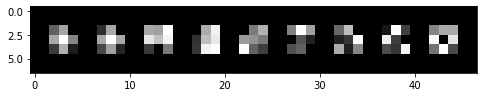

ff
[0.60903953 0.74897204 0.84866441 0.90042272 0.93921902 0.97401181
 0.987798   0.99552607 1.        ]


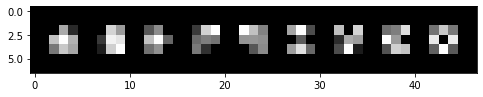

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx1383/actsoftplus/lossl1/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.37499878 0.4917952  0.59527014 0.69020988 0.75010594 0.79612092
 0.8361847  0.86622462 0.88655503 0.90514815 0.91995026 0.9303006
 0.93958029 0.94667599 0.95294465 0.95865939 0.96377319 0.96772128
 0.97106829 0.97409086]


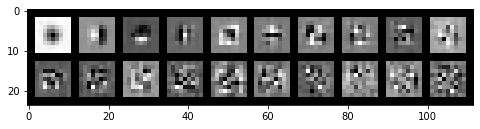

ff
[0.27527109 0.37072058 0.44722658 0.51347905 0.56795993 0.60642691
 0.64455874 0.67648001 0.70694601 0.73071896 0.75245651 0.77213886
 0.79040567 0.80810394 0.82463899 0.83821965 0.85103142 0.86188479
 0.87189322 0.88132464]


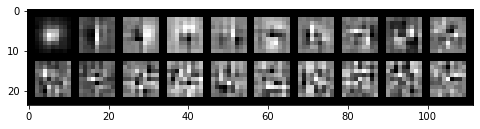

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch8/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lpoisson/m_se1, corr_norm^2 0.6057464221765619
lateral
[0.27148395 0.4894733  0.61485605 0.73543086 0.81807099 0.89932328
 0.94314682 0.98544219 1.        ]


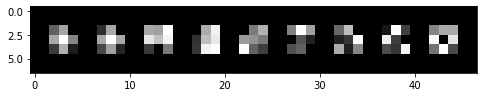

ff
[0.60903953 0.74897204 0.84866441 0.90042272 0.93921902 0.97401181
 0.987798   0.99552607 1.        ]


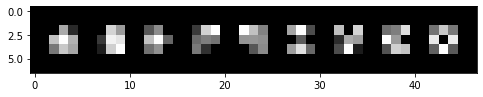

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx1446/actsoftplus/lossmse/k9/bn_preTrue/model_seed0
lateral
[0.26169502 0.39087885 0.49764643 0.57539608 0.63205194 0.67777945
 0.71308806 0.74520631 0.77336737 0.79610428 0.81582576 0.83157225
 0.84630806 0.85871525 0.87096237 0.88190409 0.89147824 0.90009178
 0.90827204 0.91498791]


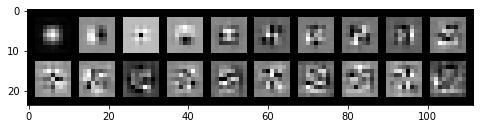

ff
[0.21090135 0.32001601 0.39518564 0.44758391 0.49231309 0.53229103
 0.56541528 0.59476079 0.6232605  0.64664551 0.66748778 0.68639507
 0.70385398 0.71931116 0.73309523 0.74575984 0.75806639 0.76999448
 0.78162035 0.79225751]


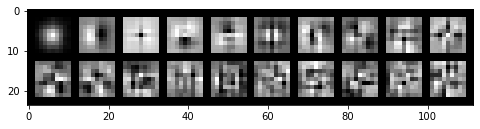

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch16/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lpoisson/m_se1, corr_norm^2 0.6560397679703807
lateral
[0.32481856 0.49462142 0.65286718 0.76045662 0.84807015 0.92316548
 0.95852351 0.98182652 1.        ]


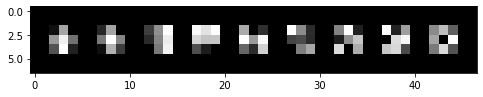

ff
[0.46470775 0.63022238 0.76922277 0.85513011 0.91118381 0.95808502
 0.97536003 0.99049847 1.        ]


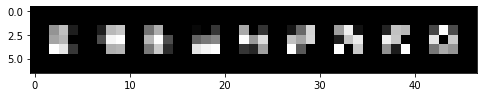

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx1447/actrelu/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.34301143 0.46063804 0.52832616 0.59339061 0.65292323 0.70752416
 0.74814815 0.78365216 0.81100753 0.82940472 0.84500906 0.85843943
 0.87100001 0.88275482 0.89367681 0.90283135 0.91104772 0.91866464
 0.92500243 0.93053696]


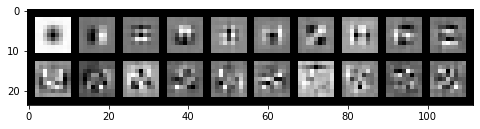

ff
[0.19822477 0.29625088 0.37095874 0.44130235 0.48497003 0.52564565
 0.56117536 0.59353027 0.62315206 0.64718447 0.66915747 0.68944869
 0.70864565 0.72745024 0.74296676 0.75805115 0.77175797 0.78445245
 0.79562078 0.80671967]


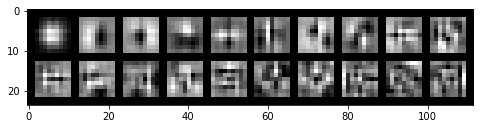

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch16/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lpoisson/m_se1, corr_norm^2 0.6473001994061082
lateral
[0.34249359 0.51356436 0.65803928 0.75652165 0.84723518 0.92700517
 0.9560018  0.98036097 1.        ]


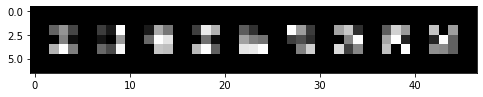

ff
[0.51370294 0.67001026 0.7802284  0.8639875  0.91872187 0.9604937
 0.97667247 0.99053642 1.        ]


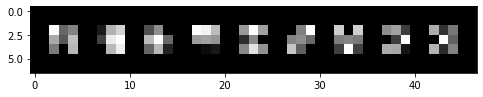

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx1447/actsoftplus/lossl1/k9/bn_preTrue/model_seed0
lateral
[0.27263579 0.38643207 0.48081159 0.54574641 0.6068909  0.65853598
 0.70360542 0.73671651 0.76685543 0.78641072 0.80523956 0.82268546
 0.83630602 0.8482186  0.8599364  0.8702157  0.88017621 0.88936158
 0.89800843 0.90491517]


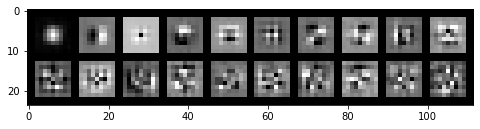

ff
[0.22978798 0.31893003 0.39311796 0.45196917 0.49877769 0.53655096
 0.57284551 0.60282075 0.62951856 0.65203764 0.6730528  0.69211343
 0.709571   0.72558375 0.74042477 0.75479217 0.76804086 0.77941284
 0.79001801 0.80022831]


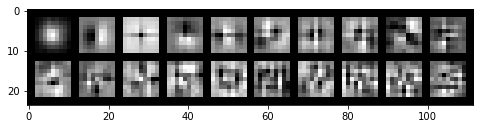

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch16/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lpoisson/m_se1, corr_norm^2 0.6473001994061082
lateral
[0.34249359 0.51356436 0.65803928 0.75652165 0.84723518 0.92700517
 0.9560018  0.98036097 1.        ]


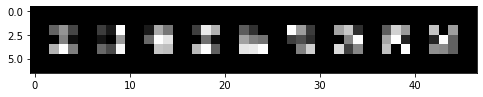

ff
[0.51370294 0.67001026 0.7802284  0.8639875  0.91872187 0.9604937
 0.97667247 0.99053642 1.        ]


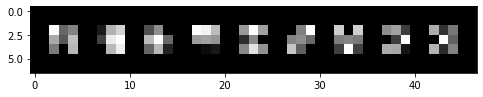

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx1510/actrelu/lossl1/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.30908437 0.4472082  0.54107844 0.60827051 0.66337224 0.70254686
 0.73974577 0.77421295 0.803943   0.82718095 0.84413296 0.85841836
 0.87094002 0.8806776  0.88920956 0.89733182 0.9045624  0.91098741
 0.91702506 0.92276322]


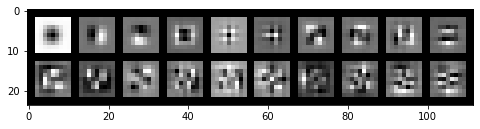

ff
[0.19253861 0.27888243 0.35251332 0.41212191 0.46341565 0.50580074
 0.53847654 0.56928873 0.59513265 0.61914081 0.64265131 0.66398215
 0.68317076 0.70159169 0.71792611 0.73179614 0.74466763 0.75724632
 0.76930613 0.78015587]


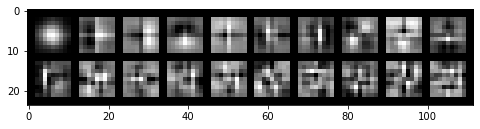

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch32/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lpoisson/m_se1, corr_norm^2 0.6769850353199182
lateral
[0.33748459 0.51227298 0.6536486  0.78948713 0.86815814 0.94160595
 0.96389282 0.98416193 1.        ]


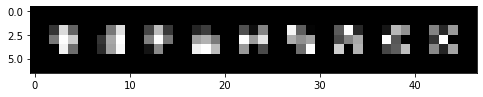

ff
[0.43502338 0.61541227 0.75006379 0.85245002 0.91021172 0.95361192
 0.97208512 0.98929042 1.        ]


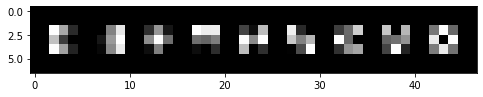

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx1511/actrelu/lossmse/k9/bn_preTrue/model_seed0
lateral
[0.28357775 0.40152724 0.48773961 0.55791563 0.61503306 0.6540864
 0.68849983 0.7195516  0.74872949 0.76838751 0.78639162 0.80150432
 0.8145502  0.82731088 0.83859281 0.84920551 0.85821081 0.86637033
 0.87415283 0.88144327]


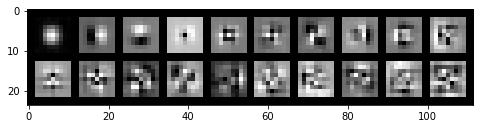

ff
[0.23559637 0.327961   0.40726896 0.4633198  0.50251929 0.53536461
 0.56631383 0.59530396 0.6195161  0.64080927 0.66012484 0.6763669
 0.69193061 0.70688885 0.7195804  0.73149032 0.74276591 0.75298639
 0.7628227  0.77239809]


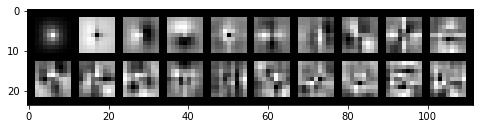

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch32/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lpoisson/m_se1, corr_norm^2 0.6682068712511656
lateral
[0.4082035  0.58071475 0.70584182 0.81346374 0.88497724 0.94425662
 0.9647419  0.98297129 1.        ]


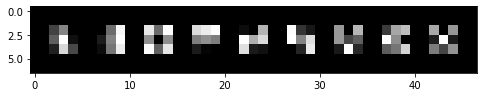

ff
[0.44488092 0.61826959 0.75117486 0.8517246  0.90810886 0.95146095
 0.96928503 0.9858945  1.        ]


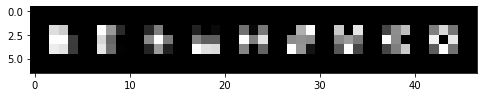

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx1511/actsoftplus/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.36074064 0.4956518  0.58838889 0.65249098 0.69491686 0.73292319
 0.76687932 0.79758384 0.82299765 0.84057126 0.85520527 0.86731338
 0.87835901 0.88709797 0.89526836 0.90221611 0.90898156 0.91520084
 0.92048202 0.92551069]


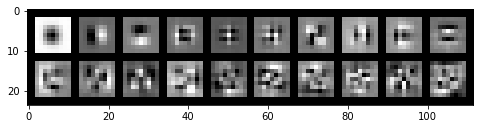

ff
[0.20653569 0.30016254 0.37949467 0.44652269 0.48569449 0.5221409
 0.5576486  0.58706389 0.61160468 0.63480213 0.65493551 0.67262242
 0.68923689 0.70404517 0.71815327 0.73153318 0.74426236 0.75591319
 0.76669001 0.77688289]


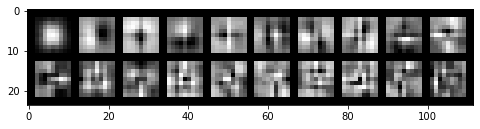

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch32/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lpoisson/m_se1, corr_norm^2 0.6682068712511656
lateral
[0.4082035  0.58071475 0.70584182 0.81346374 0.88497724 0.94425662
 0.9647419  0.98297129 1.        ]


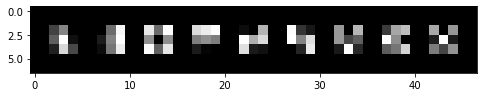

ff
[0.44488092 0.61826959 0.75117486 0.8517246  0.90810886 0.95146095
 0.96928503 0.9858945  1.        ]


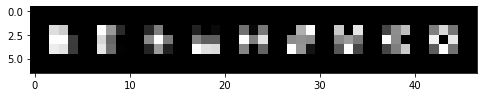

384


In [16]:
collect_all()